# Project Introduction: Integrating RSI and Bollinger Bands for Stock Analysis

## Objective
The objective of this project is to develop a reliable stock screening tool that identifies potential buy and sell signals using two popular technical indicators: the Relative Strength Index (RSI) and Bollinger Bands. By combining these indicators, we aim to enhance the accuracy of our signals, leveraging the strengths of both momentum and volatility analysis.

## Background
Technical analysis involves using historical price and volume data to forecast future price movements. Among the myriad of technical indicators available, RSI and Bollinger Bands are two widely respected tools that traders use to assess market conditions.

## Why RSI and Bollinger Bands?

### Relative Strength Index (RSI)
- **Purpose:** RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100.
- **Overbought/Oversold Conditions:** RSI values above 70 typically indicate that a stock is overbought, suggesting it might be overvalued and due for a pullback. Conversely, RSI values below 30 indicate that a stock is oversold, suggesting it might be undervalued and due for a rise.
- **Chosen Thresholds:** We chose 70 and 30 as our thresholds because they are standard in technical analysis, providing a balanced view of overbought and oversold conditions without being too conservative or too aggressive.

### Bollinger Bands
- **Purpose:** Bollinger Bands measure market volatility and provide relative high and low price levels. They consist of a middle band (a simple moving average) and two outer bands (standard deviations above and below the middle band).
- **Price Extremes:** When the price moves above the upper Bollinger Band, it indicates that the asset is relatively overbought, similar to the RSI's indication. When the price moves below the lower Bollinger Band, it indicates that the asset is relatively oversold.
- **Complementary Nature:** Bollinger Bands add a volatility perspective to RSI's momentum perspective. While RSI alone might show overbought conditions, combining it with Bollinger Bands helps to confirm whether the price is also at an extreme high relative to its recent volatility.

## Combining RSI and Bollinger Bands
By integrating RSI and Bollinger Bands, we enhance our ability to identify potential market turning points. Here’s how these indicators complement each other:
- **Enhanced Accuracy:** While RSI helps identify potential overbought and oversold conditions based on momentum, Bollinger Bands provide context by showing whether these conditions occur at price extremes relative to recent volatility.
- **Filter for False Signals:** RSI can sometimes give premature signals. By requiring that the price also be outside the Bollinger Bands, we filter out some of these false signals, increasing the likelihood that our signals are accurate.

## Methodology

- **Data Collection:** We collect historical price data for a selection of stocks over a specified period.
- **Indicator Calculation:** We calculate the RSI and Bollinger Bands for each stock.
- **Stock Screening:** We screen stocks based on the following criteria:
  - **Sell Criteria:** RSI > 70 (overbought) and price above the upper Bollinger Band.
  - **Buy Criteria:** RSI < 30 (oversold) and price below the lower Bollinger Band.
- **Visualization and Export:** We visualize the results and export the screened stocks to a CSV file for further analysis.

## Data Source and Flexibility

In this analysis, we will be using data from the FTSE 250 companies. However, feel free to use any dataset you prefer by simply changing the CSV file name in the script. Ensure that your dataset contains a column named "Ticker".

## Conclusion

This project aims to leverage the complementary strengths of RSI and Bollinger Bands to create an intriguing stock screening tool. By considering both momentum and volatility, our signals offer interesting insights designed to inspire further analysis. The chosen thresholds are standard and widely accepted in technical analysis, providing a thought-provoking starting point for potential future exploration.


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import contextlib
import sys
import os
from tqdm import tqdm

# Function to suppress print statements
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    data['MA20'] = data['Close'].rolling(window=window).mean()
    data['BB_Upper'] = data['MA20'] + (data['Close'].rolling(window=window).std() * num_std_dev)
    data['BB_Lower'] = data['MA20'] - (data['Close'].rolling(window=window).std() * num_std_dev)
    return data

# Define threshold parameters
rsi_overbought = 70  # RSI threshold to determine overbought condition
rsi_oversold = 30    # RSI threshold to determine oversold condition

# Function to analyze stock for RSI and Bollinger Bands
def analyze_stock_rsi_bb(symbol):
    try:
        # Fetch historical price data for the last 7 months
        end_date = datetime.now() - timedelta(days=1)
        start_date = end_date - timedelta(days=9*30)  # Approx. 7 months

        # Suppress yfinance output
        with suppress_output():
            data = yf.download(symbol, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        
        if data.empty:
            print(f"No data fetched for {symbol}")
            return None

        # Calculate RSI and Bollinger Bands
        data = calculate_rsi(data)
        data = calculate_bollinger_bands(data)

        data.dropna(subset=['RSI', 'MA20', 'BB_Upper', 'BB_Lower'], inplace=True)

        if data.empty:
            print(f"Insufficient data after calculating indicators for {symbol}")
            return None

        # Determine if the stock meets any of the criteria
        latest_rsi = data['RSI'].iloc[-1]
        latest_close = data['Close'].iloc[-1]
        bb_upper = data['BB_Upper'].iloc[-1]
        bb_lower = data['BB_Lower'].iloc[-1]
        is_overbought = latest_rsi > rsi_overbought
        is_oversold = latest_rsi < rsi_oversold
        price_above_bb_upper = latest_close > bb_upper
        price_below_bb_lower = latest_close < bb_lower

        # Determine if the stock meets both criteria
        meets_criteria = (is_overbought and price_above_bb_upper) or (is_oversold and price_below_bb_lower)

        return {
            "Symbol": symbol,
            "Data": data,
            "RSI": latest_rsi,
            "Close": latest_close,
            "BB_Upper": bb_upper,
            "BB_Lower": bb_lower,
            "Overbought": is_overbought,
            "Oversold": is_oversold,
            "Price_Above_BB_Upper": price_above_bb_upper,
            "Price_Below_BB_Lower": price_below_bb_lower,
            "Meets Criteria": meets_criteria
        }

    except Exception as e:
        print(f"Error analyzing stock {symbol}: {e}")
        return None

# Load tickers from the CSV file
tickers_df = pd.read_csv('ftse_250_tickers.csv')
symbols = tickers_df['Ticker'].tolist()

# Initialize list to store results
results = []

# Analyze each stock
for symbol in tqdm(symbols, desc="Processing stocks"):
    stock_data = analyze_stock_rsi_bb(symbol)
    if stock_data is not None and stock_data["Meets Criteria"]:  # Only include stocks meeting the criteria
        results.append(stock_data)

# Convert results to DataFrame
results_df = pd.DataFrame([{
    "Symbol": r["Symbol"],
    "RSI": r["RSI"],
    "Close": r["Close"],
    "BB_Upper": r["BB_Upper"],
    "BB_Lower": r["BB_Lower"],
    "Overbought": r["Overbought"],
    "Oversold": r["Oversold"],
    "Price_Above_BB_Upper": r["Price_Above_BB_Upper"],
    "Price_Below_BB_Lower": r["Price_Below_BB_Lower"],
    "Meets Criteria": r["Meets Criteria"]
} for r in results])

# Export results to CSV
results_df.to_csv("rsi_bb_screener_results.csv", index=False)

# Print results
results_df


Processing stocks: 100%|█████████████████████████████████████████████████████████████| 247/247 [00:26<00:00,  9.16it/s]


,Symbol,RSI,Close,BB_Upper,BB_Lower,Overbought,Oversold,Price_Above_BB_Upper,Price_Below_BB_Lower,Meets Criteria
0,DEC.L,89.492754,1248.000000,1221.633012,989.766988,True,False,True,False,True
1,SMWH.L,71.232877,1241.000000,1235.988249,1112.711751,True,False,True,False,True
2,BBH.L,83.076927,149.399994,147.386448,136.213549,True,False,True,False,True
3,LMP.L,77.777787,203.399994,202.717758,187.882239,True,False,True,False,True
4,PPH.L,92.857143,1400.000000,1382.105177,1253.894823,True,False,True,False,True
5,GFTU.L,75.258917,1035.000000,1030.241230,892.638775,True,False,True,False,True
6,EWI.L,83.561675,155.000000,154.788116,139.331882,True,False,True,False,True
7,TUI.L,10.302034,5.635000,811.363866,291.099634,False,True,False,True,True
8,WWH.L,70.689655,371.000000,370.854764,348.645236,True,False,True,False,True
9,KLR.L,83.750000,1440.000000,1432.147686,1174.452314,True,False,True,False,True


In [3]:
# Calculate and print the detailed results
total_tickers = len(tickers_df)
tickers_meeting_criteria = len(results_df)
percentage_meeting_criteria = (tickers_meeting_criteria / total_tickers) * 100

# Print results
print("My preference is a 5-20% threshold which strikes a balance, ensuring a\nfocused yet diverse selection of stocks to allow further investigations.")
print(f"Tickers meeting criteria: {tickers_meeting_criteria}")
print(f"Percentage of shares that pass the criteria: {percentage_meeting_criteria:.2f}%")

# Determine if the percentage is within the desired filter range
if 5 <= percentage_meeting_criteria <= 20:
    print("The percentage of shares meeting the criteria is within the desirable range (5-20%).")
else:
    print("The percentage of shares meeting the criteria is outside the desirable range (5-15%).")

My preference is a 5-20% threshold which strikes a balance, ensuring a
focused yet diverse selection of stocks to allow further investigations.
Tickers meeting criteria: 19
Percentage of shares that pass the criteria: 7.69%
The percentage of shares meeting the criteria is within the desirable range (5-20%).


The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.



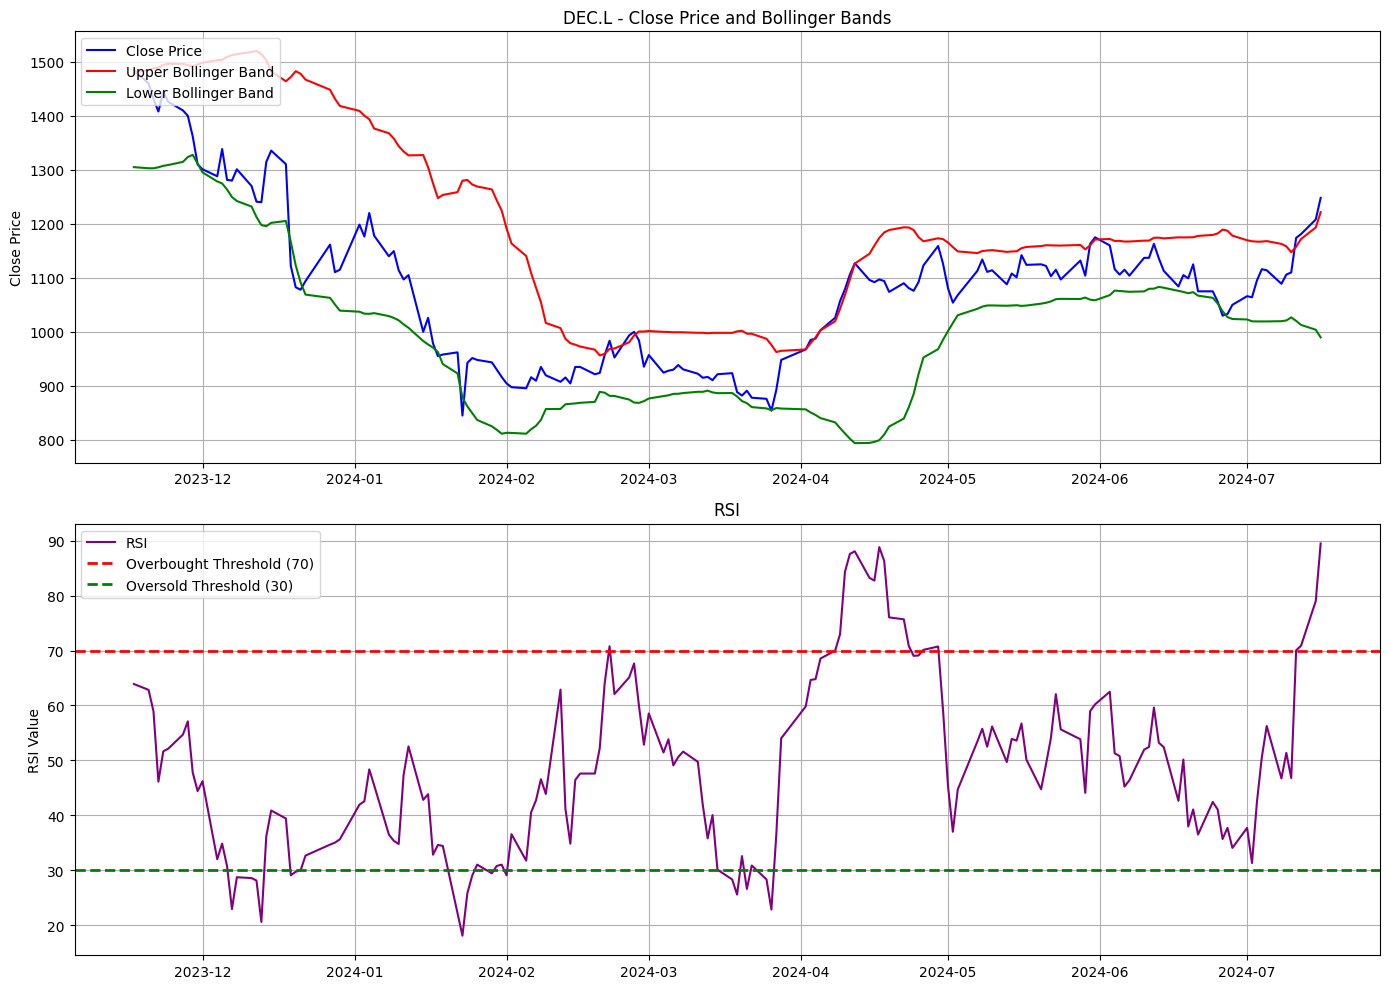

Ticker:                   DEC.L
Company:                  DIVERSIFIED ENERGY COMPANY PLC 
Sector:                   Energy
Industry:                 Oil & Gas E&P
Market Cap:               £613,958,016
Shares Outstanding:       47,263,900
52-Week High:             1930.0
52-Week Low:              822.5
PE Ratio (TTM):           1.0569569
EPS (TTM):                12.29
Dividend Yield:           0.0719
Payout Ratio:             0.2185
Revenue (TTM):            £806,788,992
Gross Profit (TTM):       N/A
Net Income (TTM):         £758,017,984
Total Debt:               £1,307,748,992
Operating Cash Flow (TTM): £410,132,000
Free Cash Flow (TTM):     £218,629,120

Description:              Diversified Energy Company PLC operates as an independent owner and operator of producing natural gas and oil wells primarily in the Appalachian Basin of the United States. The company is involved in the production, marketing, and transportation of natural gas, natural gas liquids, crude oil, and condensat

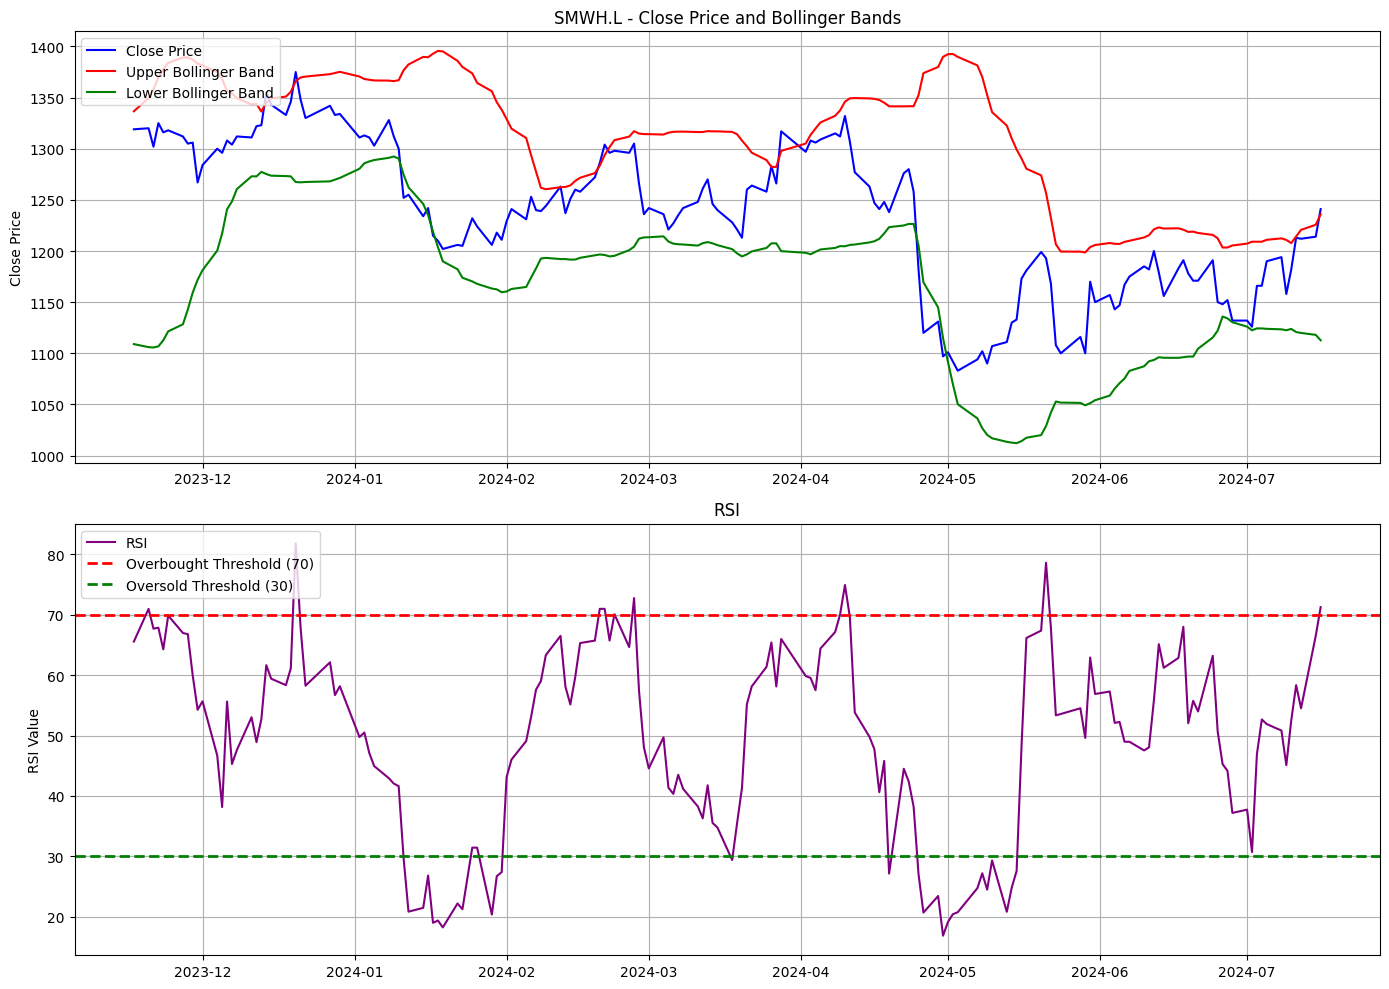

Ticker:                   SMWH.L
Company:                  WH SMITH PLC ORD 22 6/67P
Sector:                   Consumer Cyclical
Industry:                 Specialty Retail
Market Cap:               £1,645,563,904
Shares Outstanding:       130,912,000
52-Week High:             1562.0
52-Week Low:              1069.0
PE Ratio (TTM):           25.65306
EPS (TTM):                0.49
Dividend Yield:           0.0257
Payout Ratio:             0.5934
Revenue (TTM):            £1,860,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £64,000,000
Total Debt:               £1,083,000,064
Operating Cash Flow (TTM): £262,000,000
Free Cash Flow (TTM):     £82,000,000

Description:              WH Smith PLC operates as a retailer in the United Kingdom and internationally. It operates in two segments, Travel and High Street. The Travel segment offers news, books, and convenience for travelling customers. It operates stores in airports, hospitals, railway stations, and motorway service a

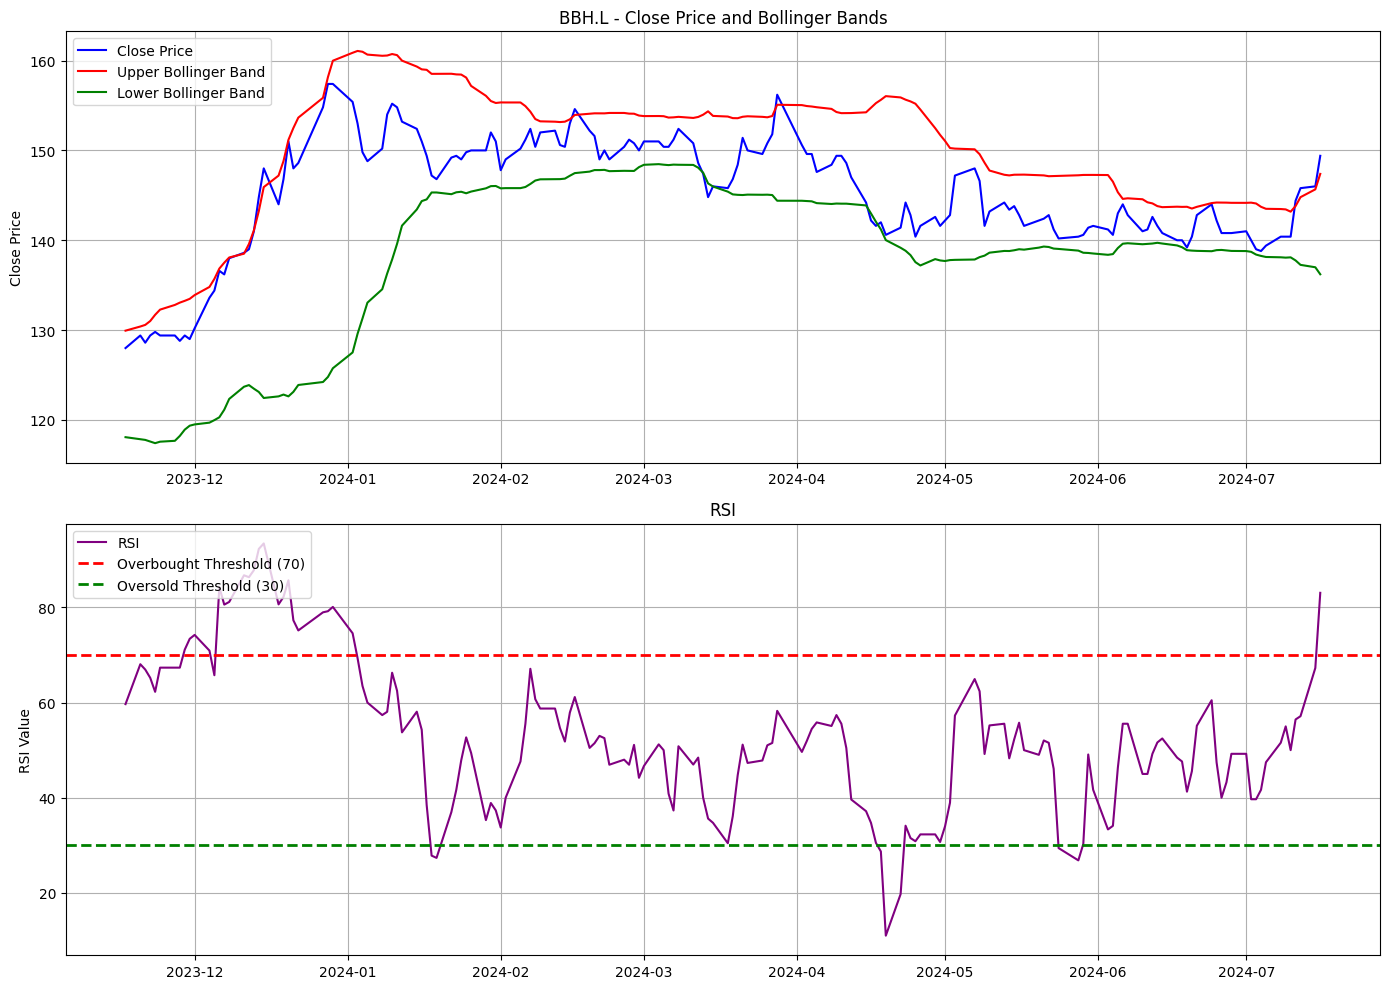

Ticker:                   BBH.L
Company:                  BELLEVUE HEALTHCARE TRUST PLC R
Sector:                   N/A
Industry:                 N/A
Market Cap:               £685,919,104
Shares Outstanding:       N/A
52-Week High:             166.58
52-Week Low:              119.399
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


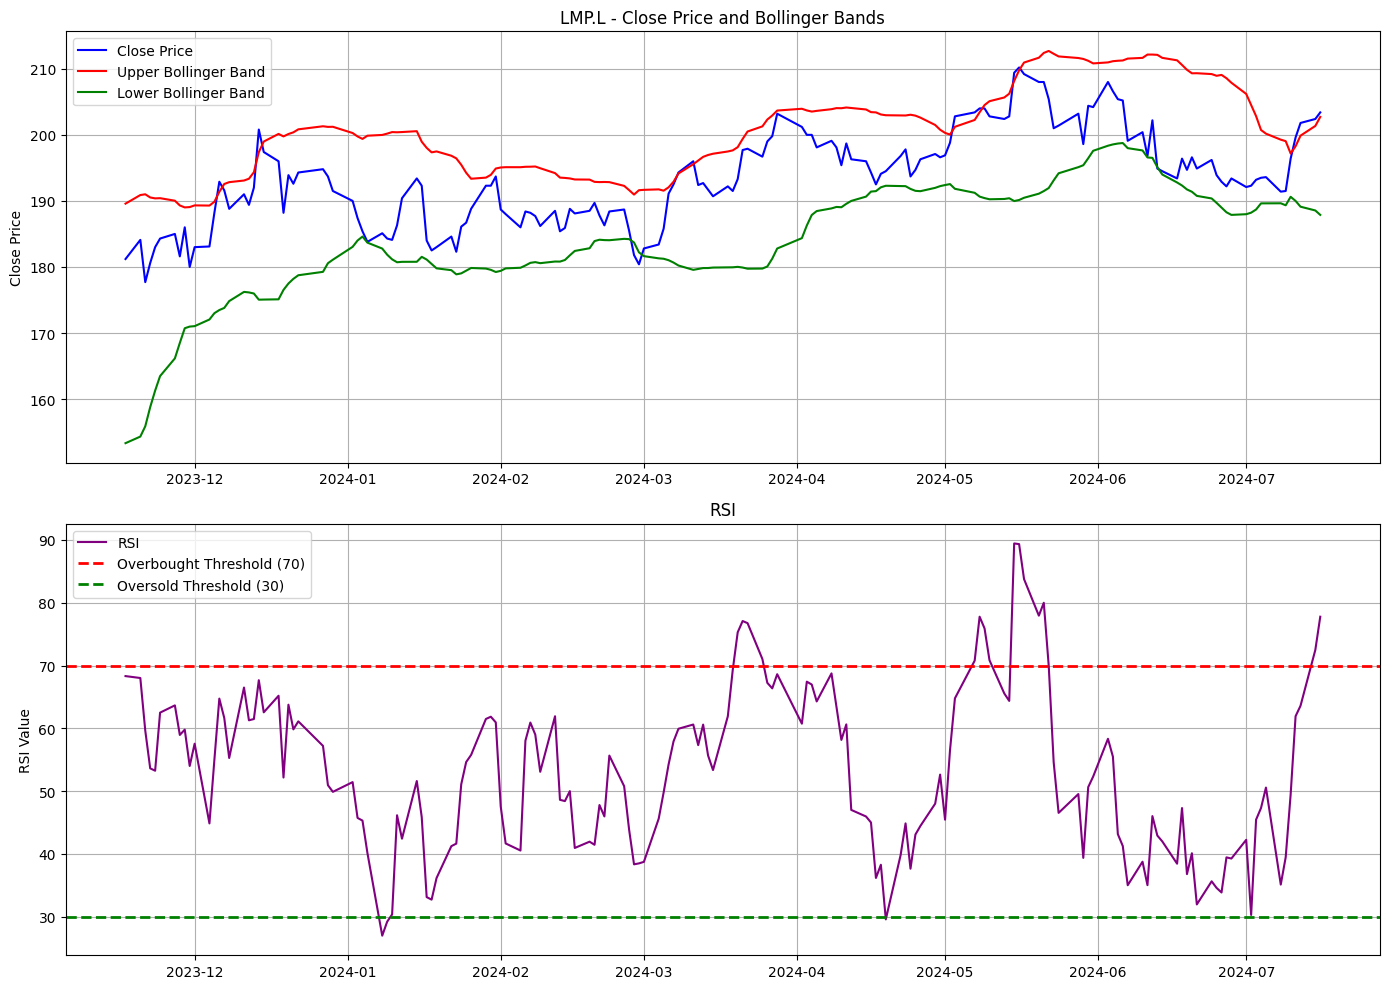

Ticker:                   LMP.L
Company:                  LONDONMETRIC PROPERTY PLC ORD 1
Sector:                   Real Estate
Industry:                 REIT - Diversified
Market Cap:               £4,128,947,456
Shares Outstanding:       2,037,980,032
52-Week High:             210.8
52-Week Low:              152.3
PE Ratio (TTM):           18.418182
EPS (TTM):                0.11
Dividend Yield:           0.0504
Payout Ratio:             0.9245
Revenue (TTM):            £178,000,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £118,700,000
Total Debt:               £2,343,699,968
Operating Cash Flow (TTM): £123,100,000
Free Cash Flow (TTM):     £163,237,504

Description:              LondonMetric is a FTSE 250 REIT that owns one of the UK's leading listed logistics platforms alongside a grocery-led long income portfolio, with 17 million sq ft under management. It owns and manages desirable real estate that meets occupiers' demands, delivers reliable, repetitive and growing

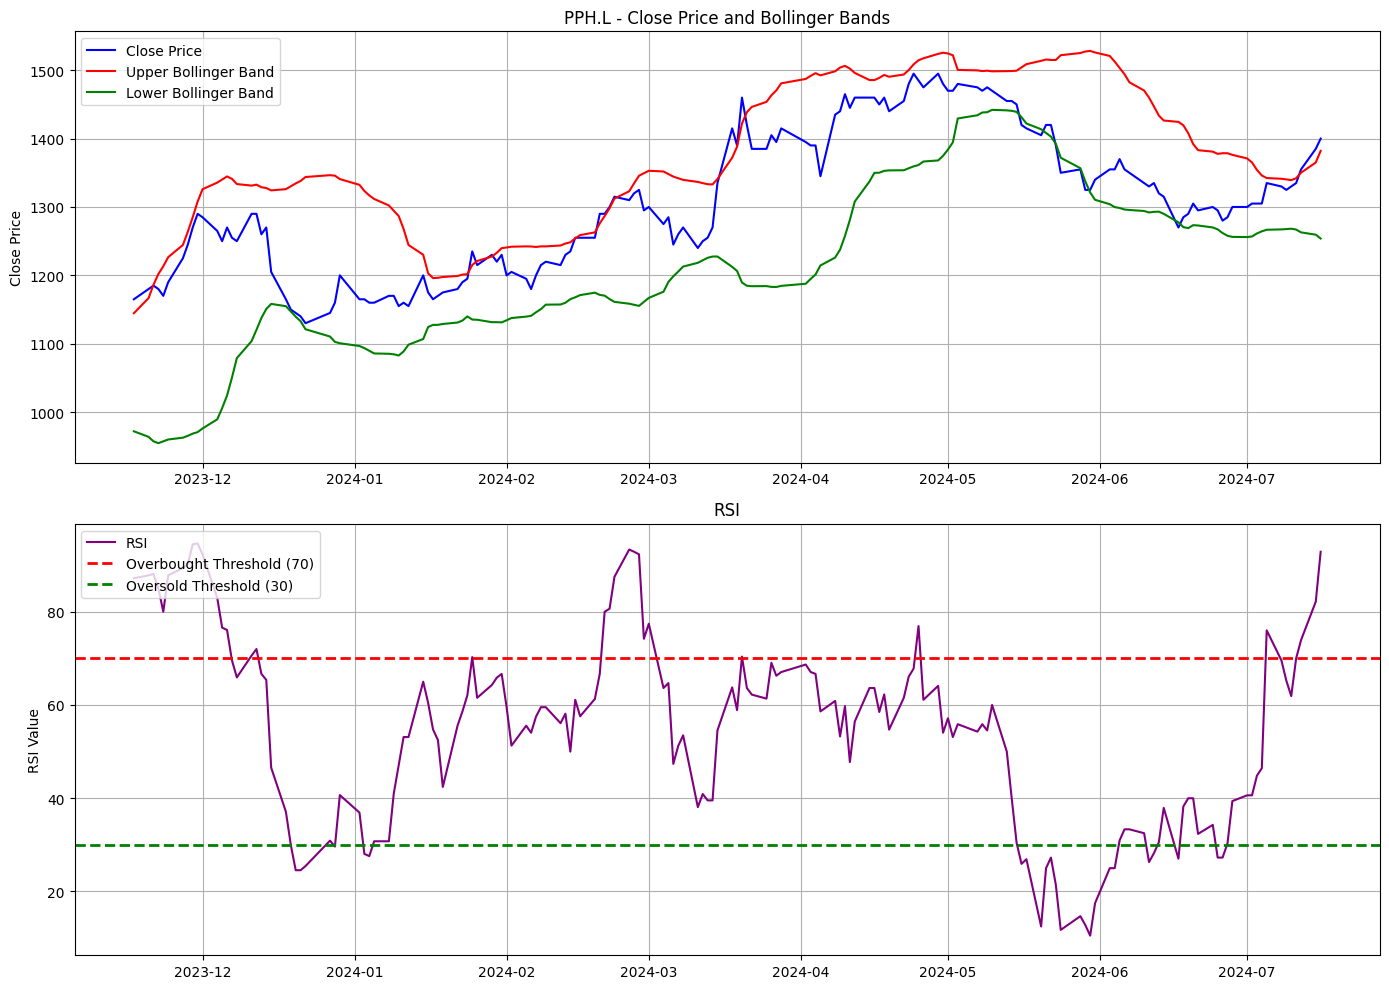

Ticker:                   PPH.L
Company:                  PPHE HOTEL GROUP LIMITED ORD NP
Sector:                   Consumer Cyclical
Industry:                 Lodging
Market Cap:               £599,572,992
Shares Outstanding:       42,075,300
52-Week High:             1530.75
52-Week Low:              1000.0
PE Ratio (TTM):           26.886793
EPS (TTM):                0.53
Dividend Yield:           0.0254
Payout Ratio:             0.52830005
Revenue (TTM):            £414,598,016
Gross Profit (TTM):       N/A
Net Income (TTM):         £22,415,000
Total Debt:               £1,170,398,976
Operating Cash Flow (TTM): £78,351,000
Free Cash Flow (TTM):     £-43,244,248

Description:              PPHE Hotel Group Limited owns, co-owns, develops, leases, operates, and franchises full-service upscale, upper upscale, and lifestyle hotels in the Netherlands, Germany, Hungary, Croatia, Serbia, Italy, Austria, and the United Kingdom. It owns and operates hotels and resorts under the Park Plaza, t

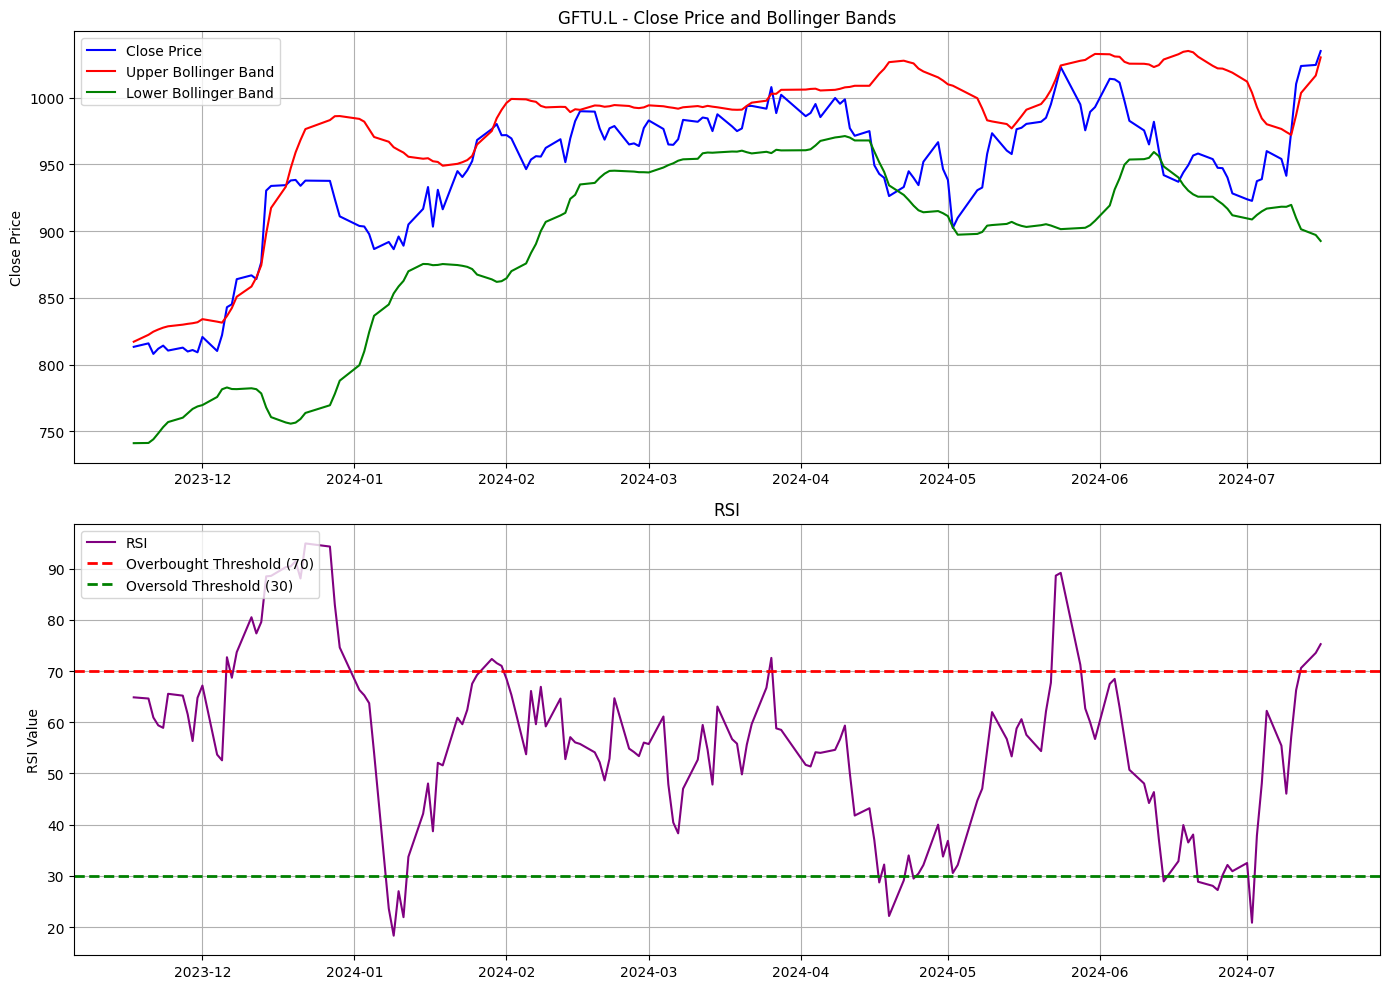

Ticker:                   GFTU.L
Company:                  GRAFTON GROUP PLC UT (1 ORD) (C
Sector:                   Industrials
Industry:                 Industrial Distribution
Market Cap:               £2,042,878,080
Shares Outstanding:       200,086,000
52-Week High:             1035.0
52-Week Low:              737.2
PE Ratio (TTM):           12.154762
EPS (TTM):                0.84
Dividend Yield:           0.0355
Payout Ratio:             0.36450002
Revenue (TTM):            £2,319,241,984
Gross Profit (TTM):       N/A
Net Income (TTM):         £148,723,008
Total Debt:               £633,201,984
Operating Cash Flow (TTM): £272,816,992
Free Cash Flow (TTM):     £199,337,376

Description:              Grafton Group plc engages in the distribution, retailing, and manufacturing businesses in Ireland, the Netherlands, Finland, and the United Kingdom. Its Distribution segment distributes building materials, paint, tools, ironmongery, fixings, and accessories, workwear and PPE, and spar

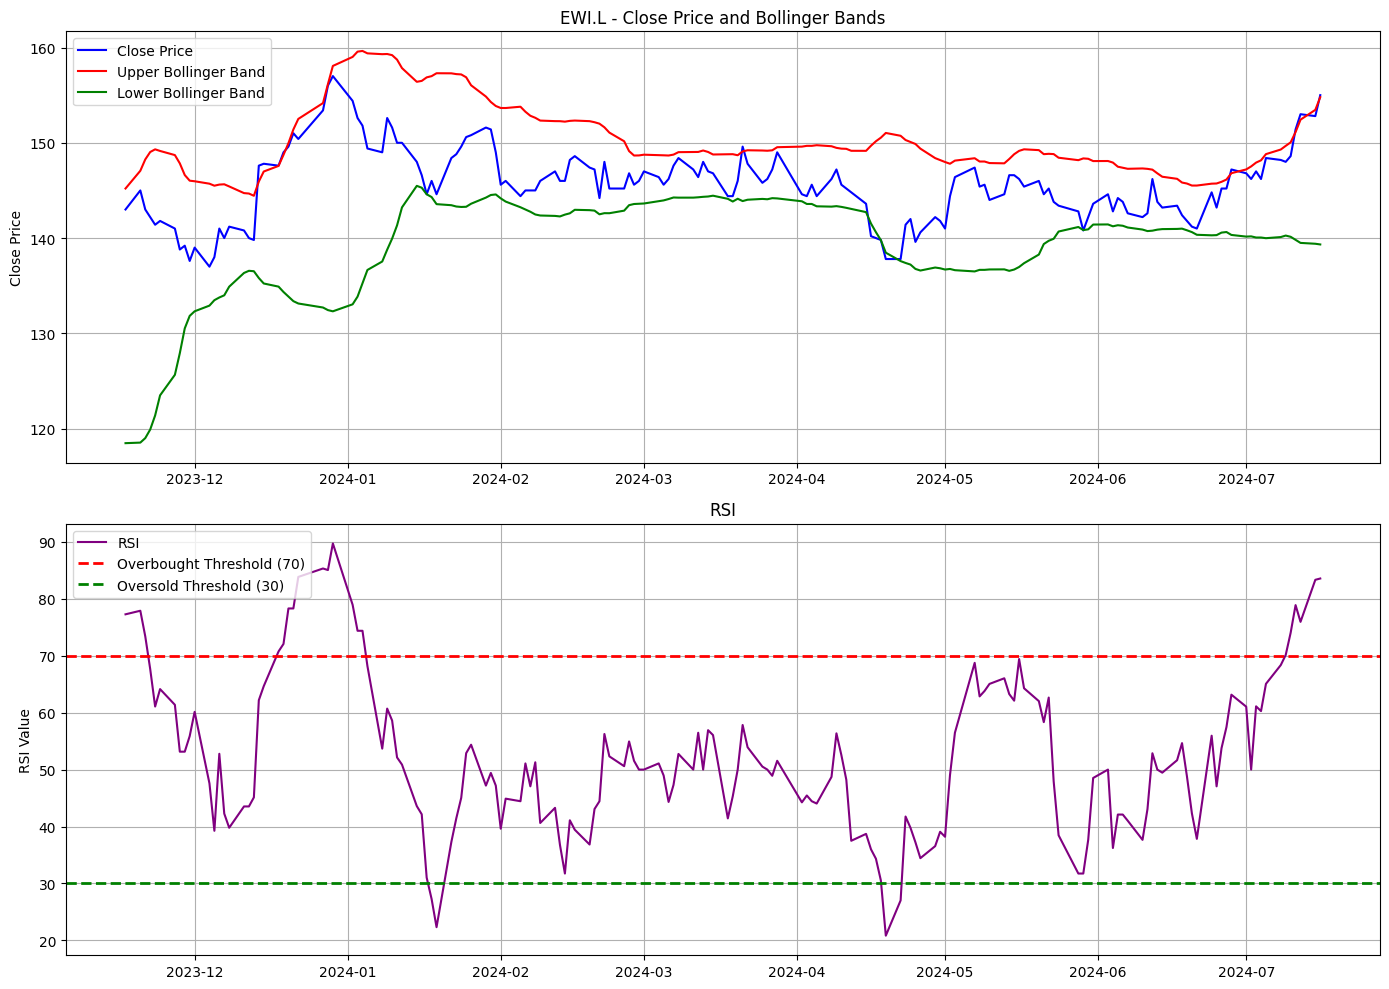

Ticker:                   EWI.L
Company:                  EDINBURGH WORLDWIDE INVESTMENT 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £593,663,936
Shares Outstanding:       N/A
52-Week High:             181.11
52-Week Low:              120.8
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


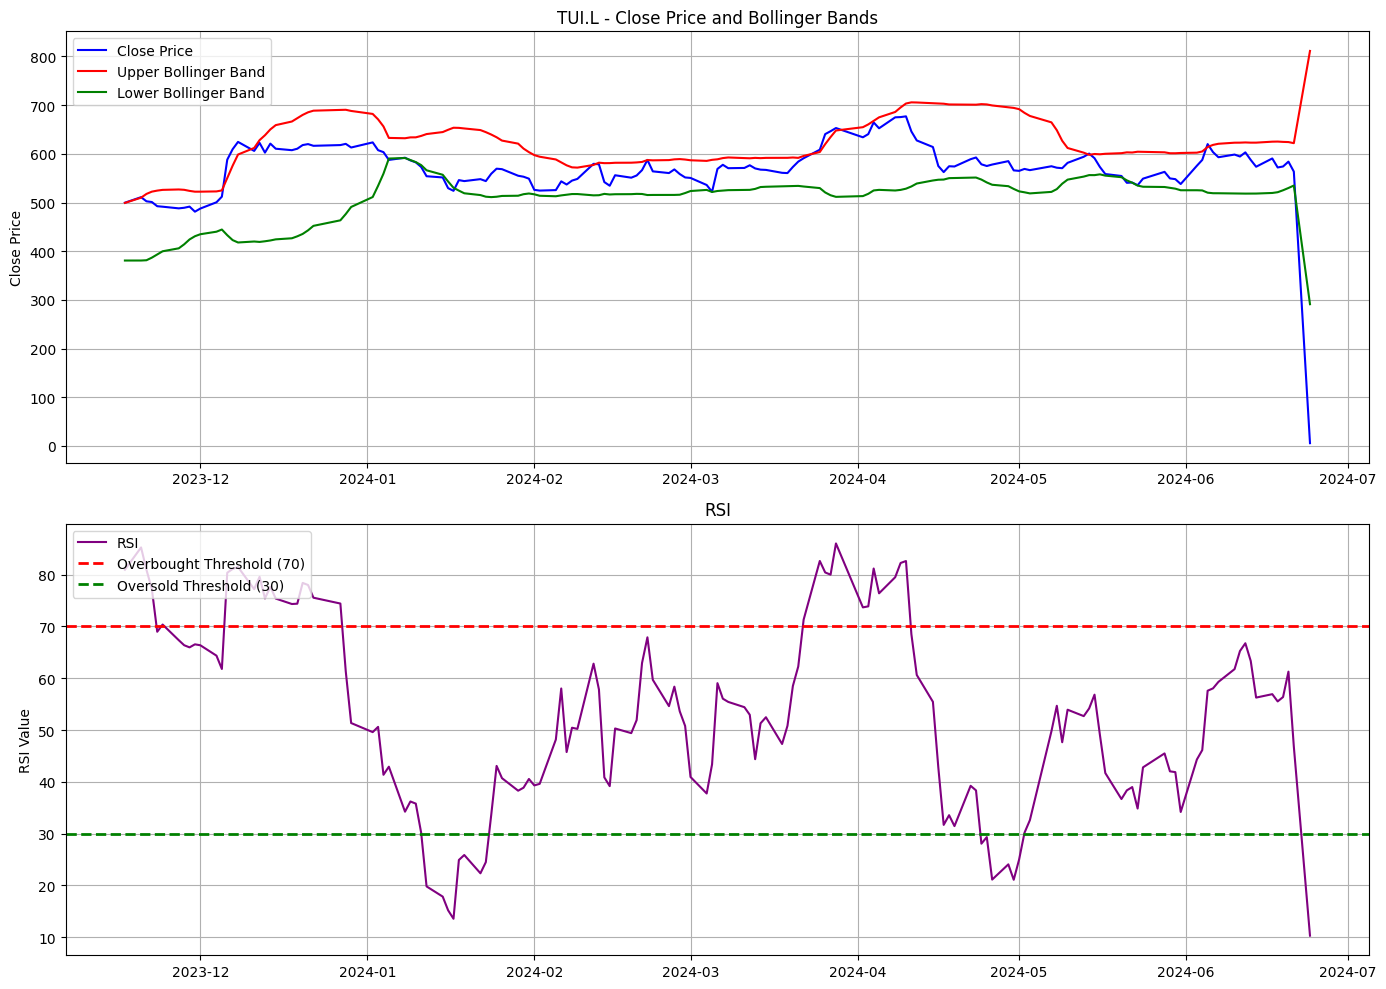

Ticker:                   TUI.L
Company:                  TUI AG ORD REG SHS NPV (DI)
Sector:                   Consumer Cyclical
Industry:                 Travel Services
Market Cap:               £2,901,760,000
Shares Outstanding:       507,431,008
52-Week High:             687.0
52-Week Low:              0.0
PE Ratio (TTM):           3.2017047
EPS (TTM):                1.76
Dividend Yield:           N/A
Payout Ratio:             0.0
Revenue (TTM):            £21,714,999,296
Gross Profit (TTM):       N/A
Net Income (TTM):         £509,400,000
Total Debt:               £4,792,099,840
Operating Cash Flow (TTM): £1,653,200,000
Free Cash Flow (TTM):     £-271,837,504

Description:              TUI AG, together with its subsidiaries, provides tourism services worldwide. It operates hotels and resorts under the Royalton, Mora, RIU Hotels & Resorts, Robinson, TUI Blue, TUI Magic Life, Atlantica Hotels & Resorts, Grupotel, Iberotel, Akra Hotels, TUI Suneo, and AQI brands. The company is also

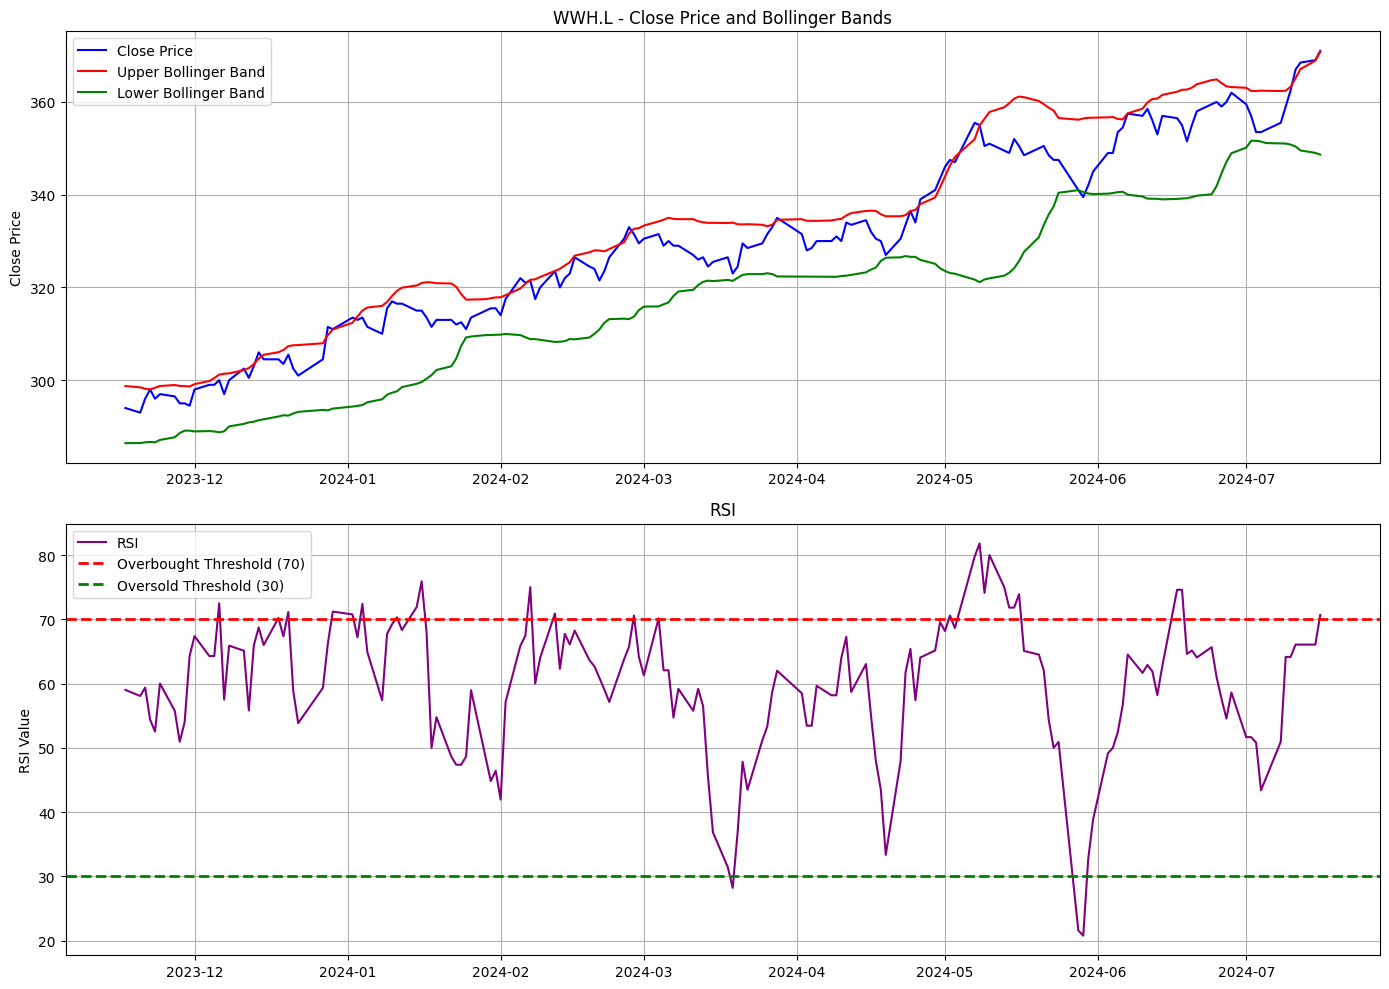

Ticker:                   WWH.L
Company:                  WORLDWIDE HEALTHCARE TRUST PLC 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £1,941,381,120
Shares Outstanding:       N/A
52-Week High:             395.42
52-Week Low:              286.0
PE Ratio (TTM):           10.812324
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


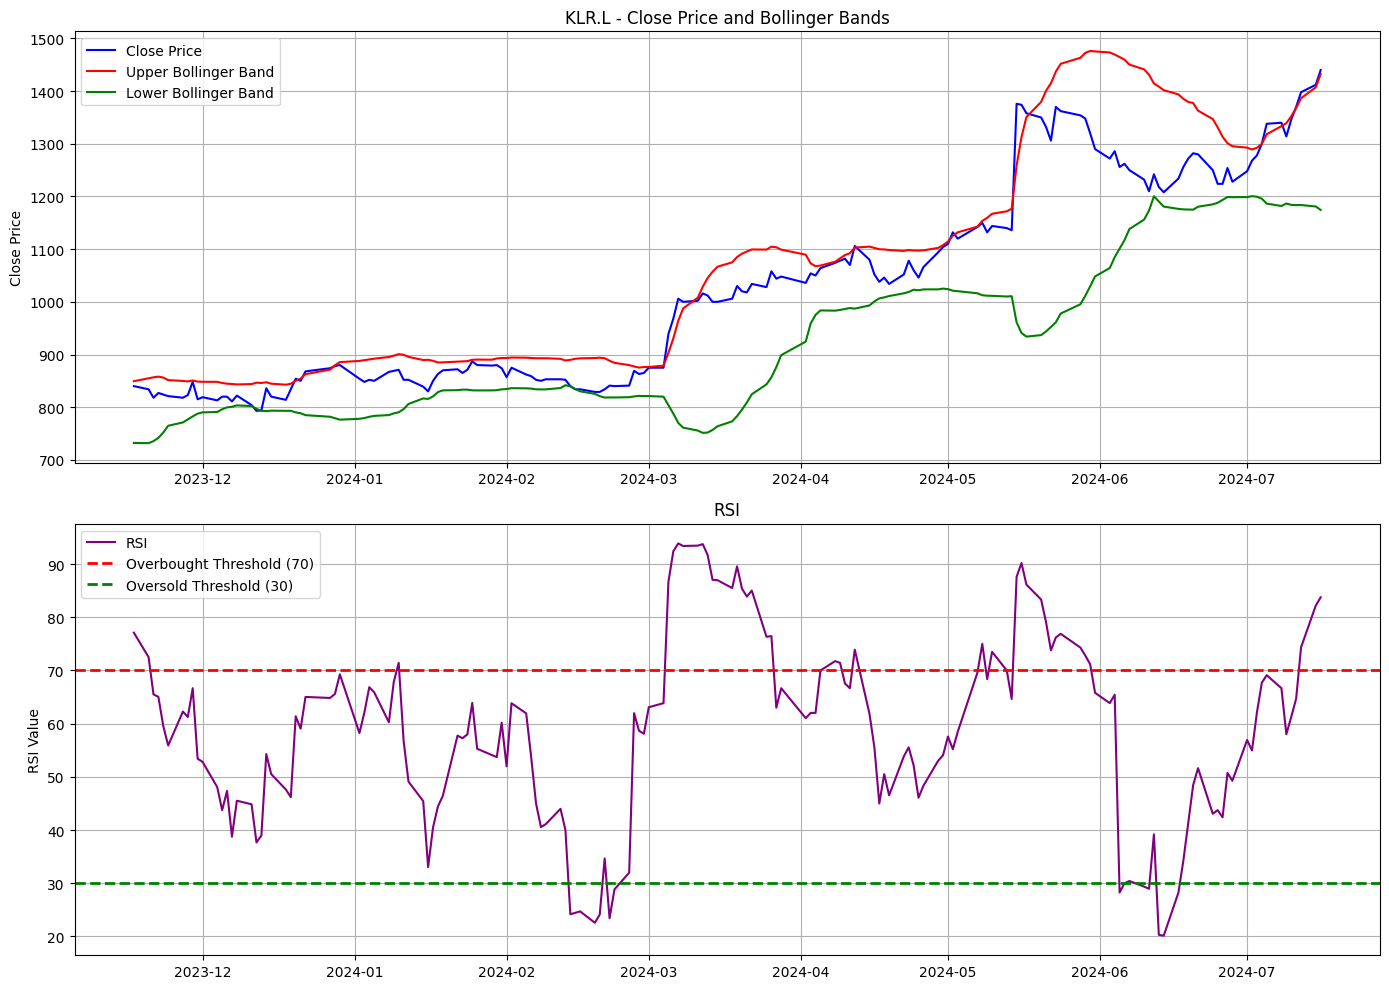

Ticker:                   KLR.L
Company:                  KELLER GROUP PLC ORD 10P
Sector:                   Industrials
Industry:                 Engineering & Construction
Market Cap:               £1,067,756,736
Shares Outstanding:       72,439,400
52-Week High:             1478.0
52-Week Low:              672.0
PE Ratio (TTM):           12.283333
EPS (TTM):                1.2
Dividend Yield:           0.0315
Payout Ratio:             0.31870002
Revenue (TTM):            £2,966,000,128
Gross Profit (TTM):       N/A
Net Income (TTM):         £89,400,000
Total Debt:               £388,700,000
Operating Cash Flow (TTM): £197,000,000
Free Cash Flow (TTM):     £144,324,992

Description:              Keller Group plc provides specialist geotechnical services in North America, Europe, the Asia-Pacific, the Middle East, and Africa. The company offers ground improvement services, grouting, deep foundations, earth retention, marine, and instrumentation and monitoring services, as well as post

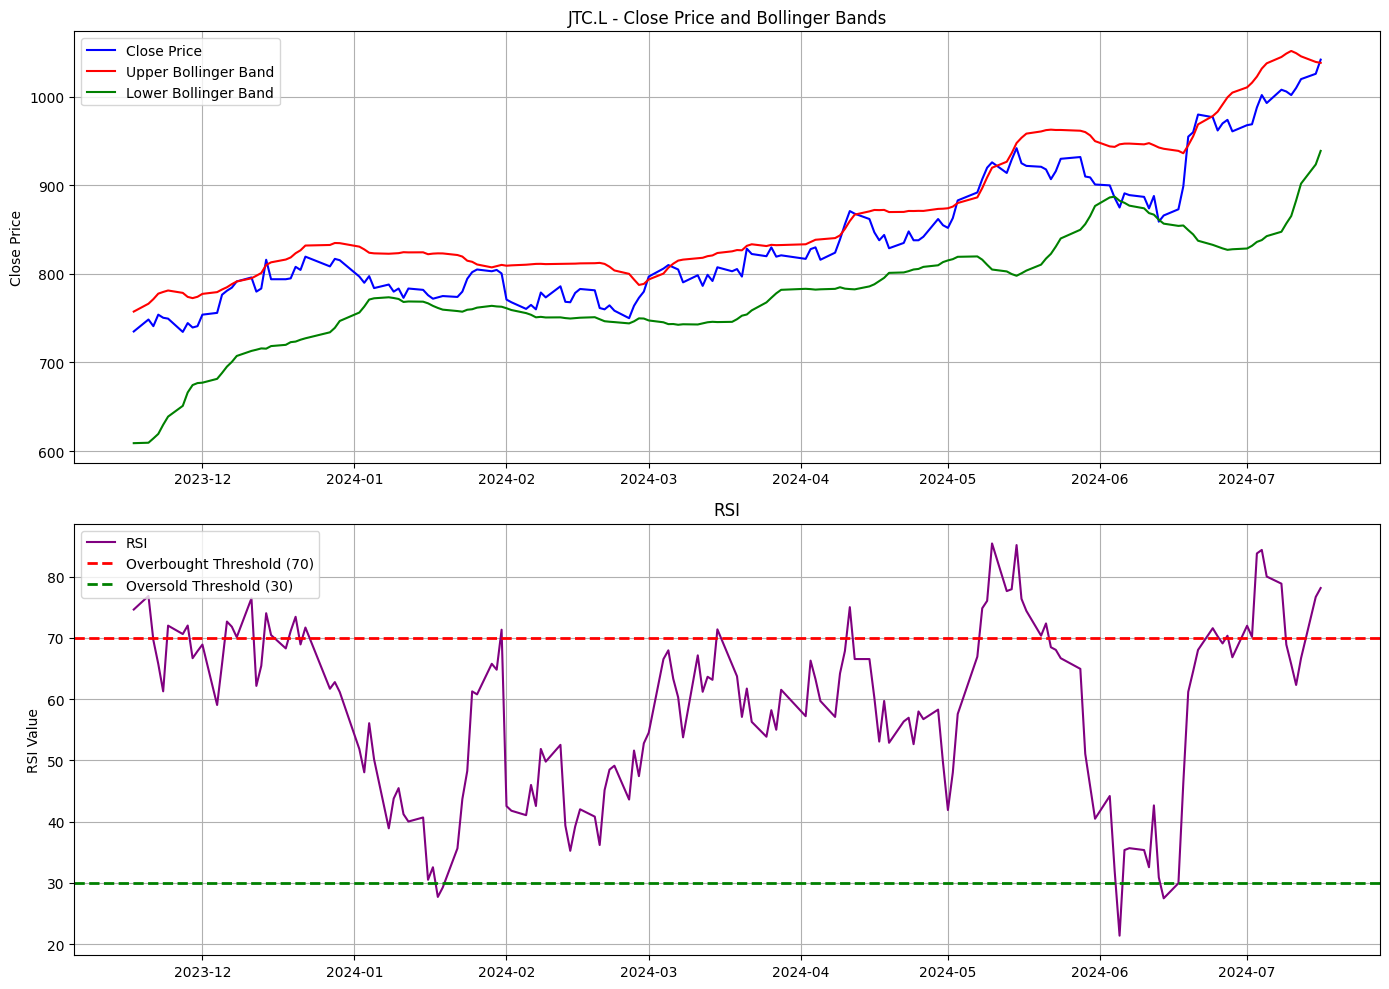

Ticker:                   JTC.L
Company:                  JTC PLC ORD GBP0.01
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £1,697,597,056
Shares Outstanding:       163,544,992
52-Week High:             1050.0
52-Week Low:              623.5
PE Ratio (TTM):           74.14286
EPS (TTM):                0.14
Dividend Yield:           0.0109
Payout Ratio:             0.7377
Revenue (TTM):            £257,440,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £21,821,000
Total Debt:               £264,572,000
Operating Cash Flow (TTM): £81,293,000
Free Cash Flow (TTM):     £84,566,624

Description:              JTC PLC provides fund, corporate, and private wealth services to institutional and private clients. The company operates in two segments, Institutional Client Services and Private Client Services. It offers fund services in a range of asset classes, including real estate, private equity, renewables, hedge, 

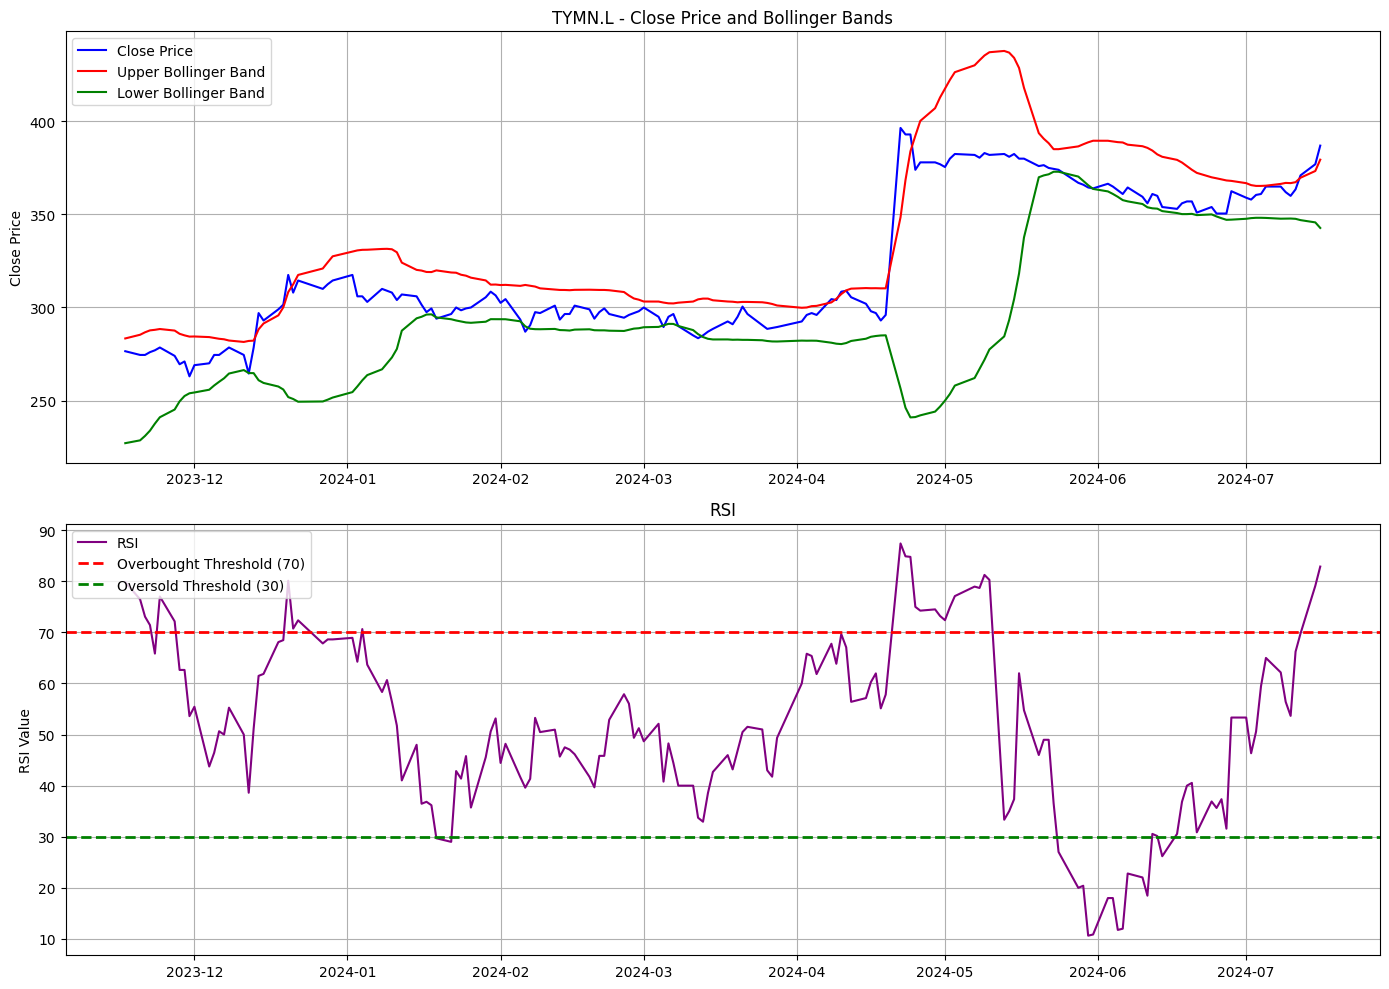

Ticker:                   TYMN.L
Company:                  TYMAN PLC ORD 5P
Sector:                   Industrials
Industry:                 Building Products & Equipment
Market Cap:               £762,281,792
Shares Outstanding:       194,956,992
52-Week High:             400.0
52-Week Low:              231.5
PE Ratio (TTM):           20.578949
EPS (TTM):                0.19
Dividend Yield:           0.035099998
Payout Ratio:             0.7026
Revenue (TTM):            £657,600,000
Gross Profit (TTM):       N/A
Net Income (TTM):         £38,200,000
Total Debt:               £231,700,000
Operating Cash Flow (TTM): £108,800,000
Free Cash Flow (TTM):     £86,400,000

Description:              Tyman plc designs, manufactures, and supplies engineered fenestration components and access solutions to the construction industry. It operates through three divisions: Tyman North America, Tyman UK & Ireland, and Tyman International. The Tyman North America division offers single and multipoint loc

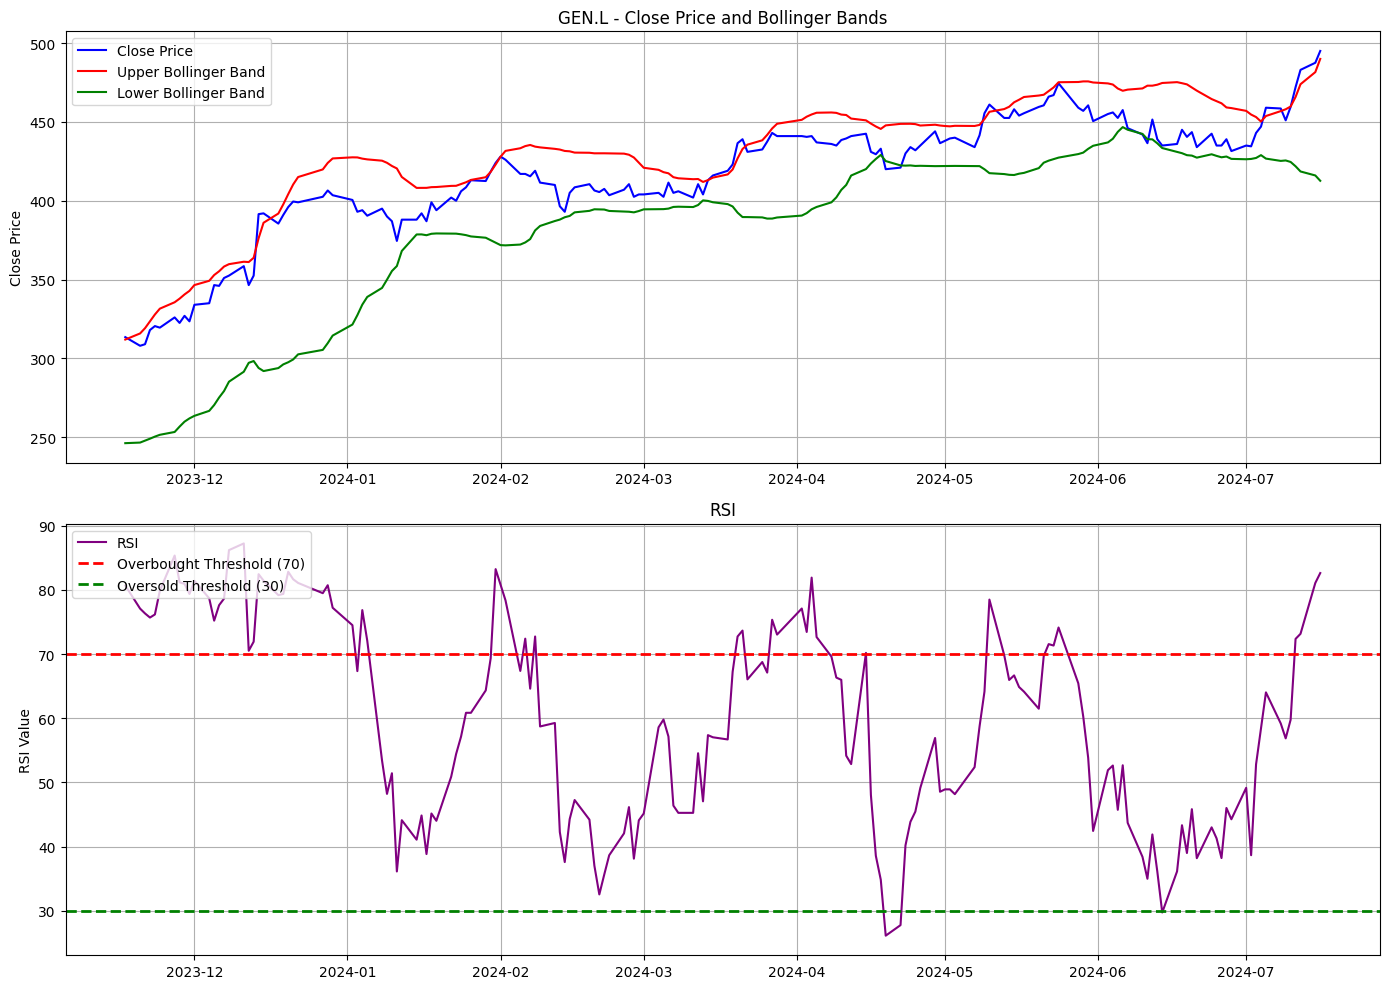

Ticker:                   GEN.L
Company:                  GENUIT GROUP PLC ORD GBP0.001
Sector:                   Industrials
Industry:                 Building Products & Equipment
Market Cap:               £1,203,491,072
Shares Outstanding:       249,170,000
52-Week High:             497.5
52-Week Low:              254.0
PE Ratio (TTM):           32.199997
EPS (TTM):                0.15
Dividend Yield:           0.025799999
Payout Ratio:             0.79870003
Revenue (TTM):            £586,499,968
Gross Profit (TTM):       N/A
Net Income (TTM):         £38,500,000
Total Debt:               £166,300,000
Operating Cash Flow (TTM): £97,600,000
Free Cash Flow (TTM):     £57,650,000

Description:              Genuit Group plc develops, manufactures, and sells water, climate, and ventilation management solutions in the United Kingdom, rest of the Europe, and internationally. The company operates through three segments: Sustainable Building Solutions, Water Management Solutions, and Climat

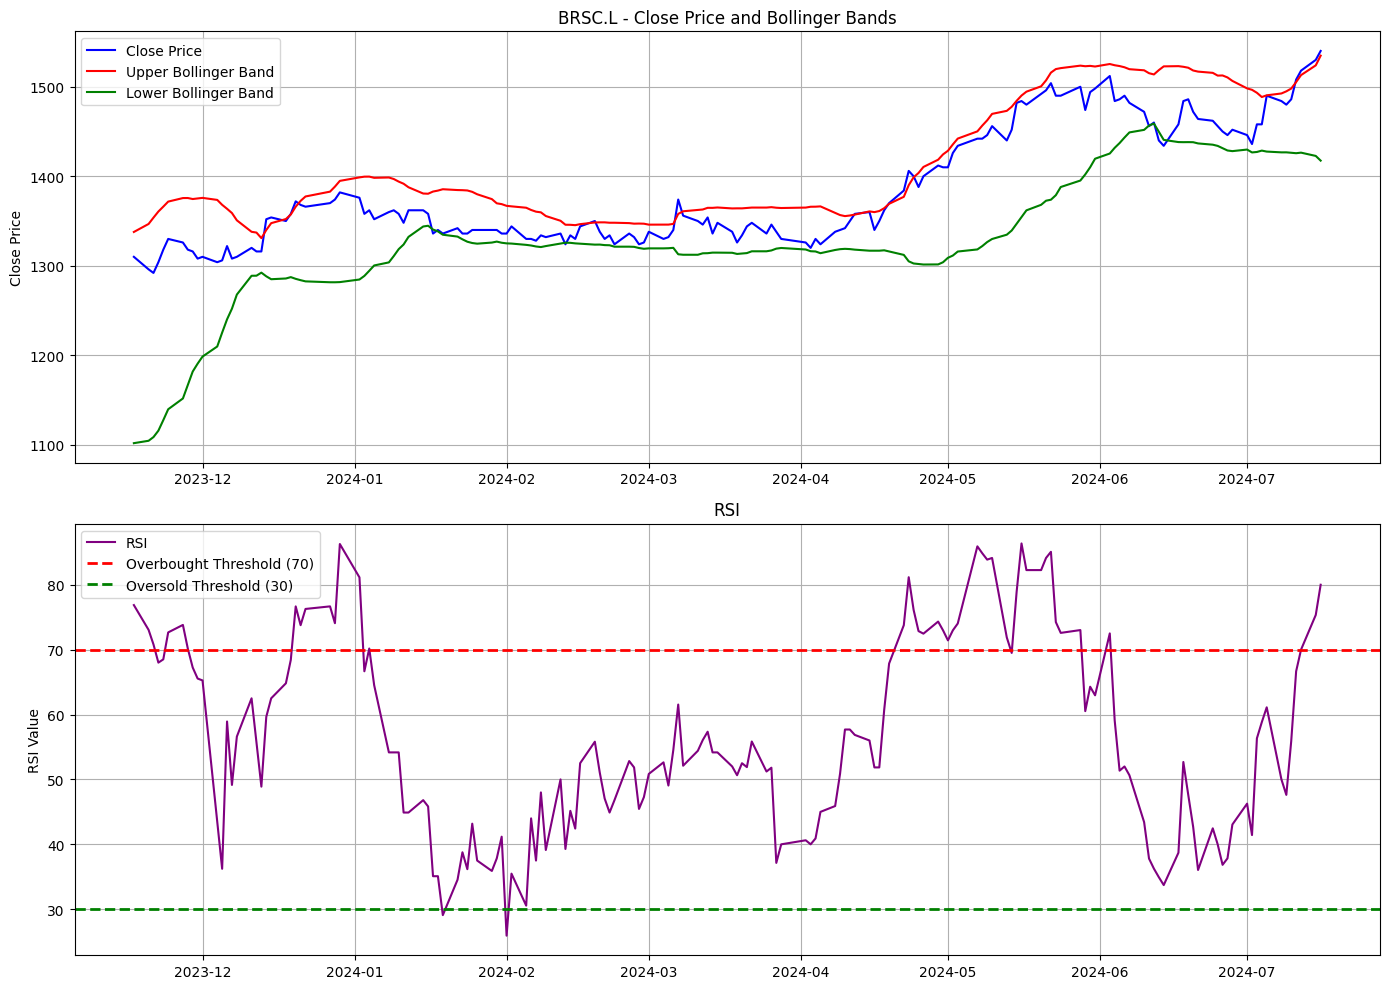

Ticker:                   BRSC.L
Company:                  BLACKROCK SMALLER CO TRUST PLC 
Sector:                   N/A
Industry:                 N/A
Market Cap:               £737,356,736
Shares Outstanding:       N/A
52-Week High:             1565.52
52-Week Low:              1146.0
PE Ratio (TTM):           N/A
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


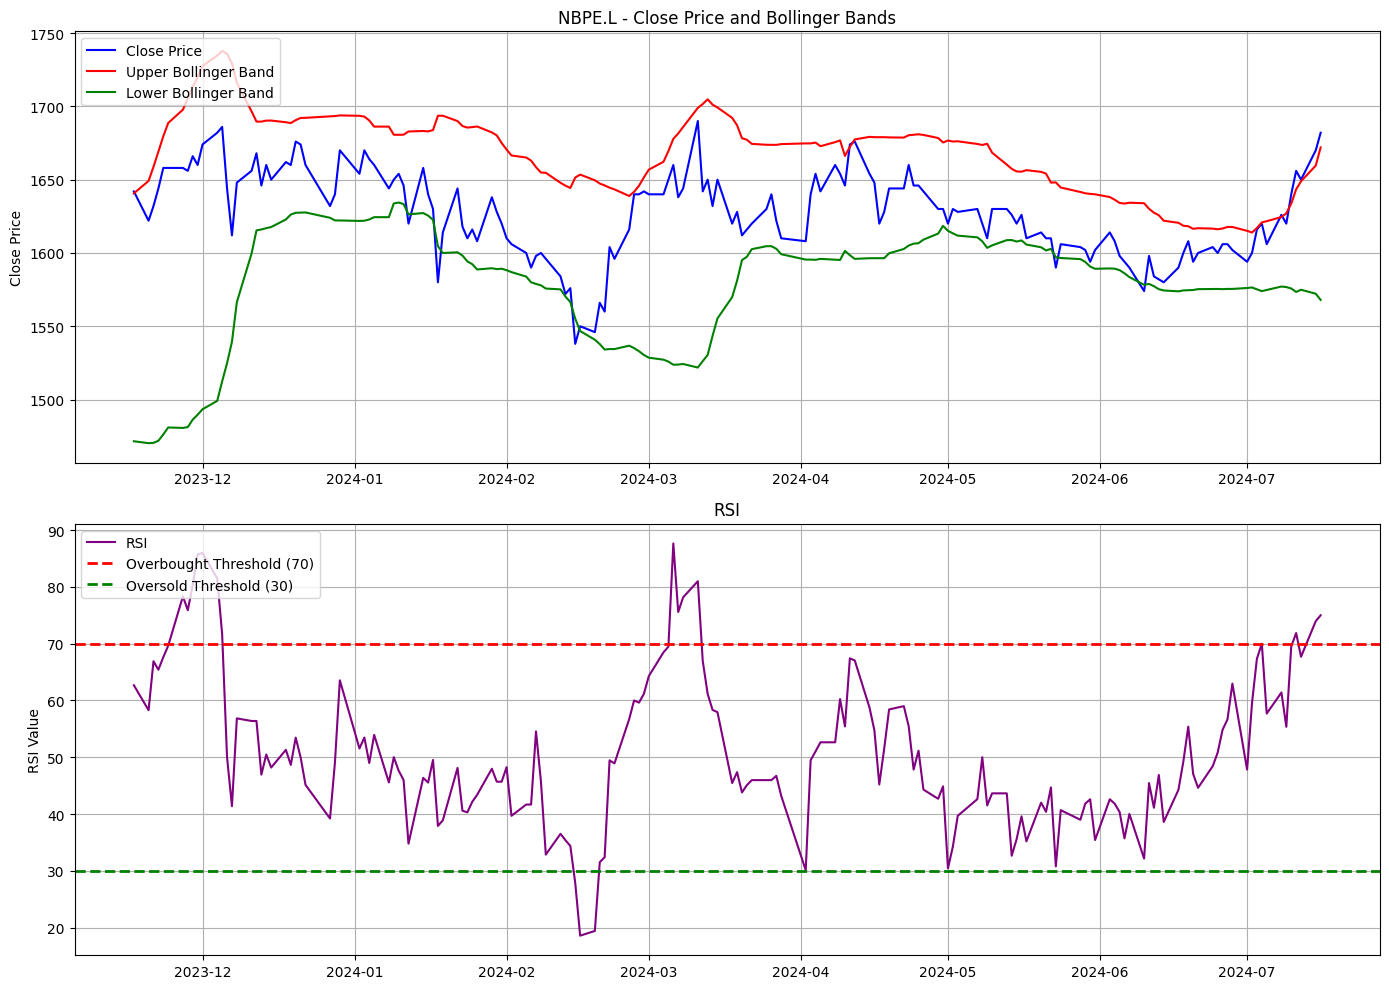

Ticker:                   NBPE.L
Company:                  NB PRIVATE EQUITY PARTNERS LIMI
Sector:                   Financial Services
Industry:                 Asset Management
Market Cap:               £765,861,888
Shares Outstanding:       46,237,700
52-Week High:             2180.647
52-Week Low:              1438.94
PE Ratio (TTM):           36.8
EPS (TTM):                0.45
Dividend Yield:           0.0434
Payout Ratio:             1.6207001
Revenue (TTM):            £7,054,768
Gross Profit (TTM):       N/A
Net Income (TTM):         £27,069,152
Total Debt:               £170,428,784
Operating Cash Flow (TTM): £2,432,721
Free Cash Flow (TTM):     £-16,250,605

Description:              NB Private Equity Partners Limited specializes in private equity fund of funds and co-investments. In fund of fund investments, it invests in private equity fund managed by other sponsors and funds of funds managed by the investment manager. In co-investments, it makes direct investments alongsid

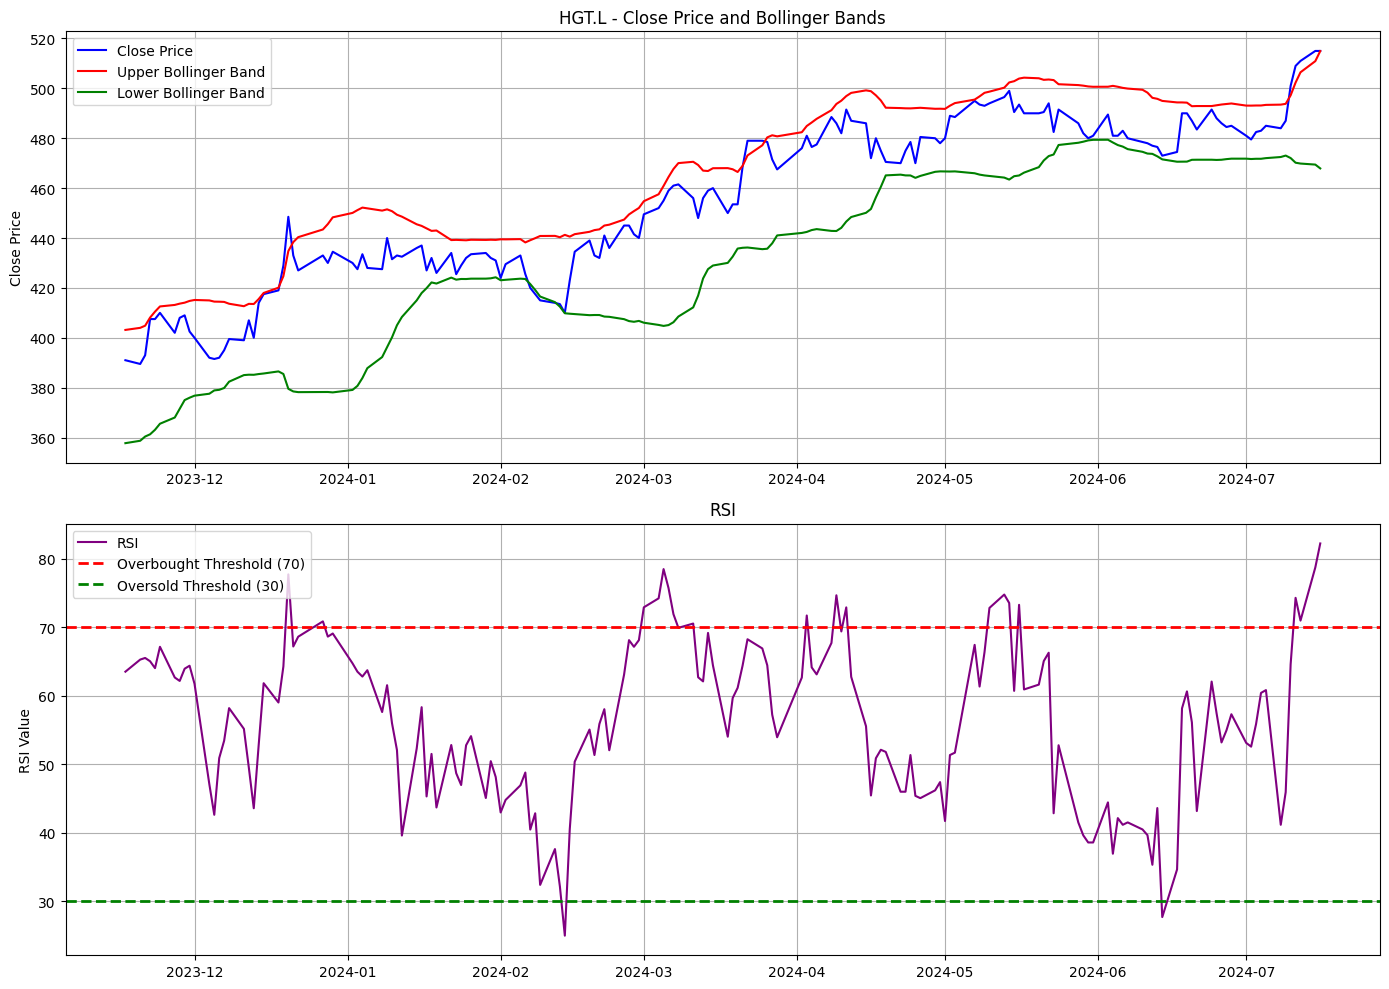

Ticker:                   HGT.L
Company:                  HG CAPITAL TRUST PLC ORD 2.5P
Sector:                   N/A
Industry:                 N/A
Market Cap:               £2,325,263,360
Shares Outstanding:       N/A
52-Week High:             517.0
52-Week Low:              357.0
PE Ratio (TTM):           10.16
EPS (TTM):                N/A
Dividend Yield:           N/A
Payout Ratio:             N/A
Revenue (TTM):            N/A
Gross Profit (TTM):       N/A
Net Income (TTM):         N/A
Total Debt:               N/A
Operating Cash Flow (TTM): N/A
Free Cash Flow (TTM):     N/A

Description:              N/A
--------------------------------------------------


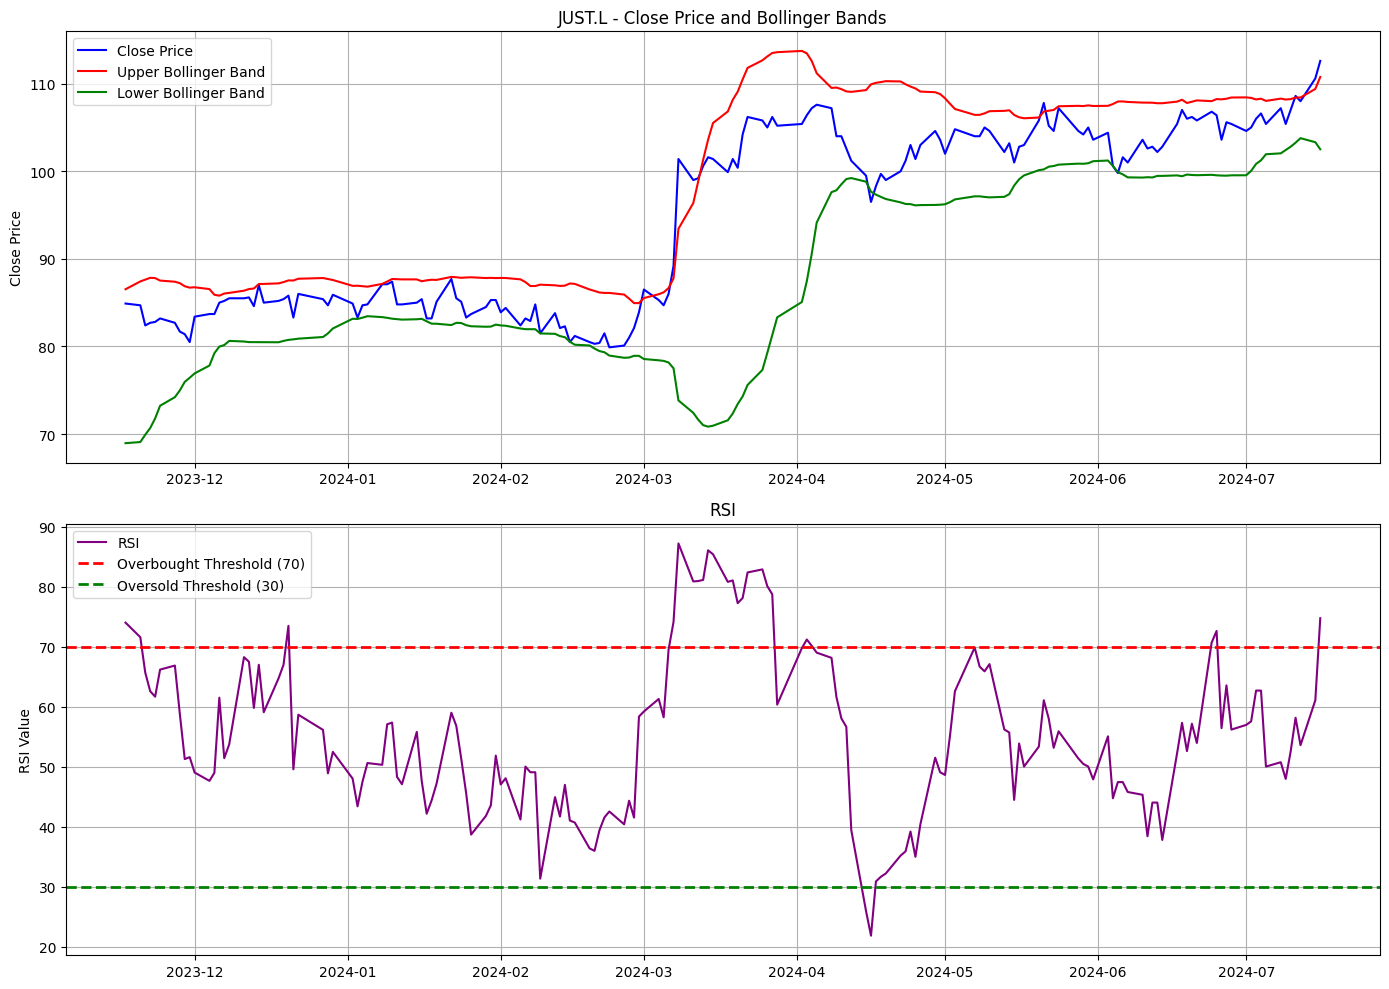

Ticker:                   JUST.L
Company:                  JUST GROUP PLC ORD 10P
Sector:                   Financial Services
Industry:                 Insurance - Specialty
Market Cap:               £1,161,266,688
Shares Outstanding:       1,038,700,032
52-Week High:             114.219
52-Week Low:              67.0
PE Ratio (TTM):           10.163637
EPS (TTM):                0.11
Dividend Yield:           0.0187
Payout Ratio:             0.1616
Revenue (TTM):            £3,143,000,064
Gross Profit (TTM):       N/A
Net Income (TTM):         £117,000,000
Total Debt:               £3,264,000,000
Operating Cash Flow (TTM): £141,000,000
Free Cash Flow (TTM):     £-6,541,125,120

Description:              Just Group plc provides various retirement income products and services to individual and corporate clients.in the United Kingdom. It offers defined benefit de-risking solutions, guaranteed income for life, secure lifetime income, care plans, and lifetime mortgage service. The company 

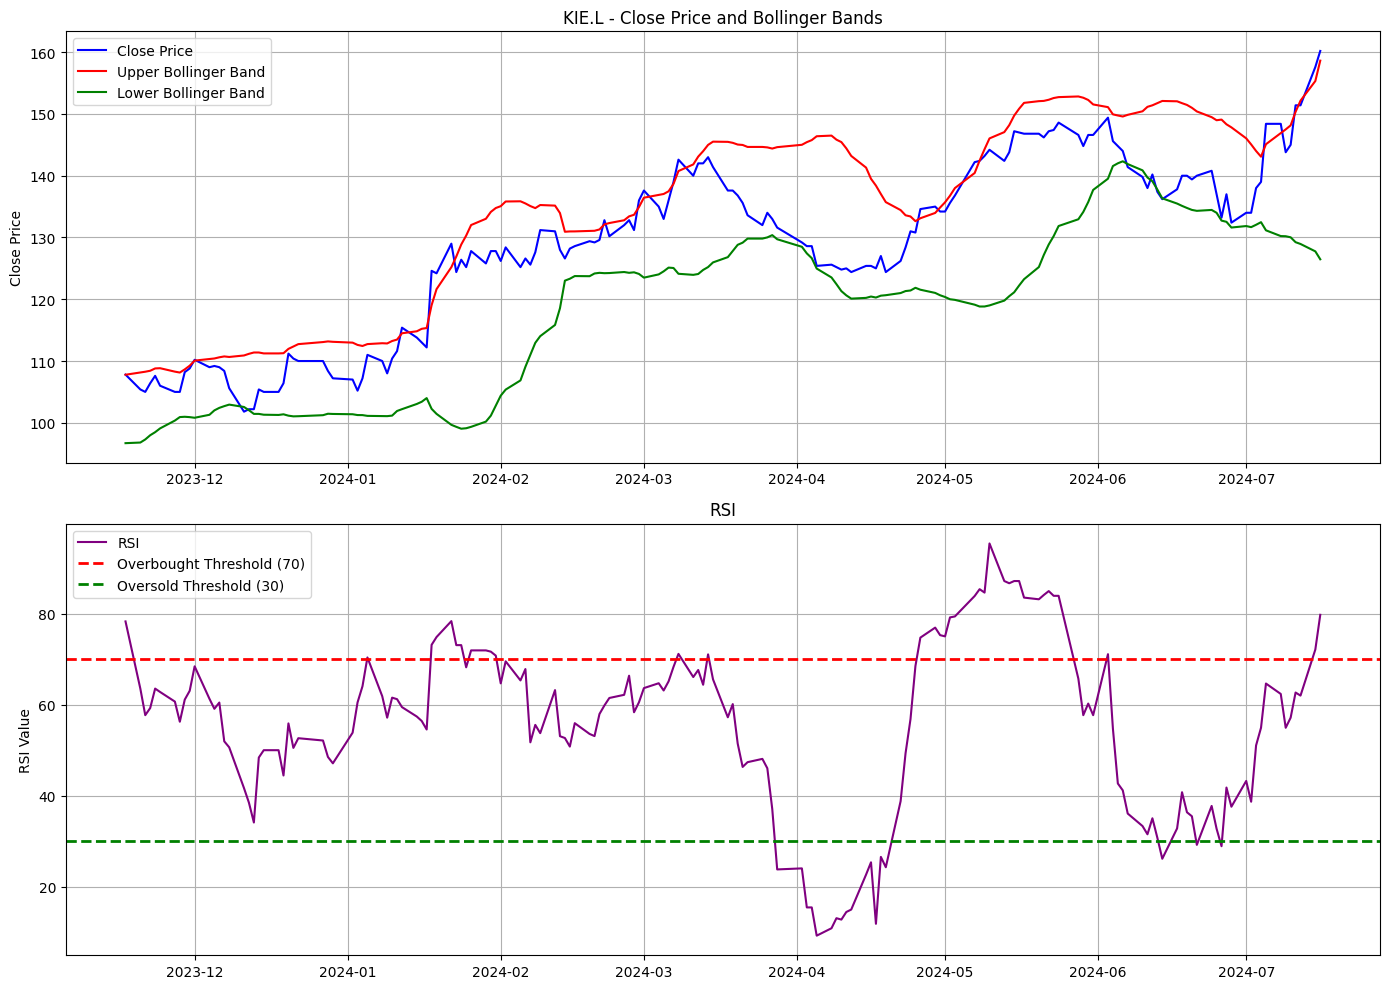

Ticker:                   KIE.L
Company:                  KIER GROUP PLC ORD 1P
Sector:                   Industrials
Industry:                 Engineering & Construction
Market Cap:               £728,840,000
Shares Outstanding:       452,134,016
52-Week High:             163.268
52-Week Low:              81.1
PE Ratio (TTM):           17.91111
EPS (TTM):                0.09
Dividend Yield:           0.021300001
Payout Ratio:             0.0
Revenue (TTM):            £3,716,999,936
Gross Profit (TTM):       N/A
Net Income (TTM):         £40,200,000
Total Debt:               £490,400,000
Operating Cash Flow (TTM): £273,100,000
Free Cash Flow (TTM):     £253,024,992

Description:              Kier Group plc primarily engages in the construction business in the United Kingdom and internationally. The company operates through three segments: Construction, Infrastructure Services, and Property. It constructs power stations, roads, bridges, railways, tunnels, and buildings for public and pr

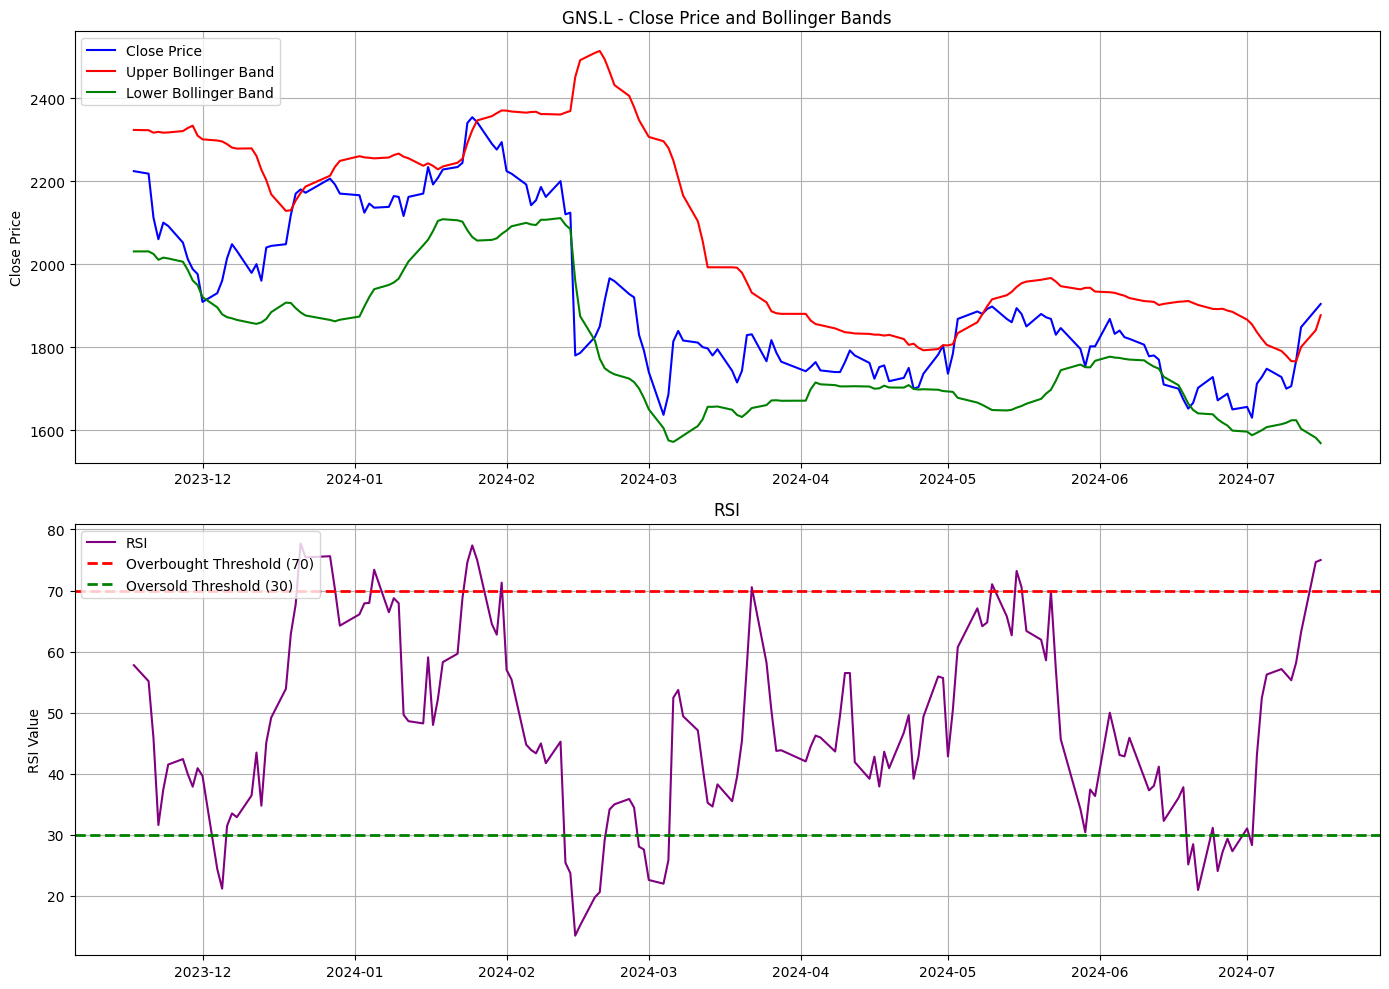

Ticker:                   GNS.L
Company:                  GENUS PLC ORD 10P
Sector:                   Healthcare
Industry:                 Biotechnology
Market Cap:               £1,139,726,080
Shares Outstanding:       66,032,800
52-Week High:             2544.0
52-Week Low:              1478.0
PE Ratio (TTM):           33.84314
EPS (TTM):                0.51
Dividend Yield:           0.0188
Payout Ratio:             0.63240004
Revenue (TTM):            £673,100,032
Gross Profit (TTM):       N/A
Net Income (TTM):         £33,400,000
Total Debt:               £292,100,000
Operating Cash Flow (TTM): £44,600,000
Free Cash Flow (TTM):     £25,212,500

Description:              Genus plc operates as an animal genetics company in North America, Latin America, the United Kingdom, rest of Europe, the Middle East, Russia, Africa, and Asia. The company operates through three segments: Genus PIC, Genus ABS, and Genus Research and Development. It sells breeding pigs and semen to breed pigs with v

In [5]:
# Function to print basic financial data
def print_financial_data(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    def format_value(value, currency=False):
        if isinstance(value, (int, float)):
            formatted_value = f"{value:,}"
            if currency:
                formatted_value = f"£{formatted_value}"
            return formatted_value
        return value

    market_cap = format_value(info.get('marketCap', 'N/A'), currency=True)
    shares_outstanding = format_value(info.get('sharesOutstanding', 'N/A'))
    year_high = info.get('fiftyTwoWeekHigh', 'N/A')
    year_low = info.get('fiftyTwoWeekLow', 'N/A')
    pe_ratio = info.get('trailingPE', 'N/A')
    eps = info.get('trailingEps', 'N/A')
    dividend_yield = info.get('dividendYield', 'N/A')
    payout_ratio = info.get('payoutRatio', 'N/A')
    revenue = format_value(info.get('totalRevenue', 'N/A'), currency=True)
    gross_profit = format_value(info.get('grossProfits', 'N/A'), currency=True)
    net_income = format_value(info.get('netIncomeToCommon', 'N/A'), currency=True)
    total_debt = format_value(info.get('totalDebt', 'N/A'), currency=True)
    operating_cash_flow = format_value(info.get('operatingCashflow', 'N/A'), currency=True)
    free_cash_flow = format_value(info.get('freeCashflow', 'N/A'), currency=True)
    sector = info.get('sector', 'N/A')
    industry = info.get('industry', 'N/A')
    description = info.get('longBusinessSummary', 'N/A')

    print(f"{'Ticker:':<25} {ticker}")
    print(f"{'Company:':<25} {info.get('shortName', 'N/A')}")
    print(f"{'Sector:':<25} {sector}")
    print(f"{'Industry:':<25} {industry}")
    print(f"{'Market Cap:':<25} {market_cap}")
    print(f"{'Shares Outstanding:':<25} {shares_outstanding}")
    print(f"{'52-Week High:':<25} {year_high}")
    print(f"{'52-Week Low:':<25} {year_low}")
    print(f"{'PE Ratio (TTM):':<25} {pe_ratio}")
    print(f"{'EPS (TTM):':<25} {eps}")
    print(f"{'Dividend Yield:':<25} {dividend_yield}")
    print(f"{'Payout Ratio:':<25} {payout_ratio}")
    print(f"{'Revenue (TTM):':<25} {revenue}")
    print(f"{'Gross Profit (TTM):':<25} {gross_profit}")
    print(f"{'Net Income (TTM):':<25} {net_income}")
    print(f"{'Total Debt:':<25} {total_debt}")
    print(f"{'Operating Cash Flow (TTM):':<25} {operating_cash_flow}")
    print(f"{'Free Cash Flow (TTM):':<25} {free_cash_flow}")
    print(f"\n{'Description:':<25} {description}")  # Print the full description
    print("-" * 50)




# Function to plot RSI and Bollinger Bands indicators
def plot_rsi_bb(data, symbol, rsi_overbought, rsi_oversold):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Plot Close Price and Bollinger Bands
    ax1.plot(data.index, data['Close'], label='Close Price', color='blue')
    ax1.plot(data.index, data['BB_Upper'], label='Upper Bollinger Band', color='red')
    ax1.plot(data.index, data['BB_Lower'], label='Lower Bollinger Band', color='green')
    ax1.set_title(f'{symbol} - Close Price and Bollinger Bands')
    ax1.set_ylabel('Close Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot RSI
    ax2.plot(data.index, data['RSI'], label='RSI', color='purple')
    ax2.axhline(y=rsi_overbought, color='red', linestyle='--', linewidth=2, label='Overbought Threshold (70)')
    ax2.axhline(y=rsi_oversold, color='green', linestyle='--', linewidth=2, label='Oversold Threshold (30)')
    ax2.set_title('RSI')
    ax2.set_ylabel('RSI Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Print the introductory text
print("The following stocks have met the specified criteria. A plot is displayed showing the stock price and its relationship to the associated indicators. Additionally, detailed financial and company information is provided for each stock.\n")

# Iterate through all tickers to plot graphs and print financial data
for stock_data in results: 
    symbol = stock_data["Symbol"]
    data = stock_data["Data"]
    plot_rsi_bb(data, symbol, rsi_overbought, rsi_oversold)  # Call plot_rsi_bb function with stock data and symbol
    print_financial_data(symbol)  # Call print_financial_data function with symbol

